### Modelling and Overall Interpretation of Results

Overall Research Questions:
1) How do customers define 'good' service, and how does the new script shift those definitions?
2) What aspects of service (clarity, empathy, agent personality) drive variance in sentiment?
3) Does the new script systematically change perceptions or emotional tone, particularly for high-value segments like VOLT?


#### Topic Analysis
For each group (general/VOLT), answer:
- What are the top latent topics mentioned?
- How do topic distributions differ by treatment?
- What percentage of comments mention agent personality, clarity or reassurance?

#### Sentiment Analysis
- Compare:
    - Sentiment distribution between treatment vs. control
    - Strength of sentiment for VOLT vs. general sample
- What topics co-occur with negative or positive sentiment?
- Are there any shift in emotional tone driven by the new script?

#### Modelling + Interpretation

- Train a classification model to predict positive vs. negative sentiment using extracted topics of LLM embeddings
    - Identify key explainers of sentiment
- Evaluate whether treatment assignment is predictive of topic use or sentiment, controlling for segment


##### Firstly let's breakdown our whole data, which has topic and sentiment information

In [113]:
# Enhanced imports for presentation-quality visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
import re
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the most comprehensive dataset with sentiment, topics, and aspects
print("📊 Loading comprehensive dataset...")
try:
    # Try to load the most recent dataset with all enhancements
    df = pd.read_csv('../data/processed/data_with_sentiment_topics_and_aspects.csv')
    print(f"✅ Loaded data_with_sentiment_topics_and_aspects.csv: {df.shape[0]} rows, {df.shape[1]} columns")
except FileNotFoundError:
    # Fallback to previous version if the comprehensive one doesn't exist
    df = pd.read_pickle('../data/processed/data_with_sentiment_and_topics.pkl')
    print(f"⚠️  Loaded fallback dataset: {df.shape[0]} rows, {df.shape[1]} columns")

# Standardize column names for consistency across notebooks
if 'GROUP' in df.columns and 'treatment' not in df.columns:
    df['treatment'] = df['GROUP']
if 'VOLT_FLAG' in df.columns and 'volt' not in df.columns:
    df['volt'] = df['VOLT_FLAG']

# Display available columns for verification
print(f"\n📋 Available columns: {list(df.columns)}")
print(f"\n🔍 Dataset info:")
print(f"   - Treatment groups: {df['treatment'].value_counts().to_dict()}")
print(f"   - VOLT segments: {df['volt'].value_counts().to_dict()}")

# Set consistent styling for all plots
plt.style.use('default')
sns.set_palette("Set2")

# Define standard colors for consistency across all visualizations
COLORS = {
    'Control': '#2E86C1',        # Blue
    'Pilot': '#E74C3C',          # Red
    'control': '#2E86C1',        # Blue (lowercase)
    'pilot': '#E74C3C',          # Red (lowercase)
    'treatment': '#E74C3C',      # Red (for treatment group)
    'Treatment': '#E74C3C',      # Red (capitalized)
    'VOLT': '#F39C12',           # Orange
    'volt': '#F39C12',           # Orange (lowercase)
    'General': '#27AE60',        # Green
    'general': '#27AE60',        # Green (lowercase)
    'non_volt': '#27AE60',       # Green (for non-VOLT)
    'positive': '#27AE60',       # Green
    'negative': '#E74C3C',       # Red
    'neutral': '#95A5A6'         # Gray
}

📊 Loading comprehensive dataset...
✅ Loaded data_with_sentiment_topics_and_aspects.csv: 582 rows, 34 columns

📋 Available columns: ['GROUP', 'VOLT_FLAG', 'SURVEY_ID', 'SCORE', 'LTR_COMMENT', 'PRIMARY_REASON', 'MONTH', 'CONNECTION_TIME', 'SALES_PERSON_SAT', 'SALES_FRIENDLY_SAT', 'COMMINICATION_SAT', 'FIRST_BILL_SAT', 'AGENT_KNOWLEDGE', 'VOLT_FLAG_BINARY', 'TREATMENT_BINARY', 'LTR_COMMENT_CLEAN', 'SENTIMENT_SCORE', 'SENTIMENT_MAGNITUDE', 'topics_assigned', 'substantive_topics', 'num_topics_assigned', 'aspect_agent_personality', 'aspect_agent_mentions', 'aspect_communication_support', 'aspect_clarity_communication', 'aspect_support_actions', 'aspect_process_experience', 'aspect_technical_service', 'aspect_financial_products', 'aspect_timeliness', 'aspect_competitive_retention', 'aspect_contact_patterns', 'aspects_enhanced', 'num_aspects_enhanced', 'treatment', 'volt']

🔍 Dataset info:
   - Treatment groups: {'control': 335, 'pilot': 247}
   - VOLT segments: {'yes': 241}


### Topic Analysis: Understanding Customer Concerns

**Research Questions:**
- What are the top topics mentioned across segments?
- How do topic distributions differ by treatment?
- What percentage of comments mention service quality themes (agent personality, clarity, reassurance)?

In [128]:
# ========================================================================
# COMPREHENSIVE TOPIC ANALYSIS
# ========================================================================

# Convenience masks for analysis
is_volt = df["VOLT_FLAG_BINARY"] == 1
is_gen = df["VOLT_FLAG_BINARY"] == 0
is_treat = df["TREATMENT_BINARY"] == 1
is_ctrl = df["TREATMENT_BINARY"] == 0

def enhanced_aspect_analysis(df_subset, name):
    """Enhanced aspect analysis using the available aspect columns"""
    aspect_cols = [col for col in df_subset.columns if col.startswith('aspect_')]
    
    aspect_summary = {}
    total_comments = len(df_subset)
    
    for aspect_col in aspect_cols:
        aspect_name = aspect_col.replace('aspect_', '').replace('_', ' ').title()
        aspect_count = df_subset[aspect_col].sum()
        aspect_pct = aspect_count / total_comments * 100
        aspect_summary[aspect_name] = {
            'count': aspect_count,
            'percentage': aspect_pct
        }
    
    # Sort by frequency
    sorted_aspects = sorted(aspect_summary.items(), key=lambda x: x[1]['count'], reverse=True)
    
    return {
        'name': name,
        'aspects': sorted_aspects,
        'n_comments': total_comments,
        'total_aspects': len(aspect_cols)
    }

def topic_analysis_from_assigned(df_subset, name):
    """Analyze topics from the topics_assigned column"""
    topics_list = []
    for topics_str in df_subset['topics_assigned'].dropna():
        try:
            if isinstance(topics_str, str) and topics_str.strip():
                # Split by comma and clean
                topics = [t.strip() for t in topics_str.split(',') if t.strip()]
                topics_list.extend(topics)
        except:
            continue
    
    topic_counts = Counter(topics_list)
    topic_coverage = len(df_subset['topics_assigned'].dropna()) / len(df_subset)
    
    return {
        'name': name,
        'top_topics': topic_counts.most_common(10),
        'total_mentions': len(topics_list),
        'unique_topics': len(topic_counts),
        'coverage': topic_coverage,
        'n_comments': len(df_subset)
    }

print("🔍 ASPECT & TOPIC ANALYSIS BY SEGMENT & TREATMENT")
print("=" * 60)

# Generate comprehensive analysis breakdowns
analysis_results = []
for segment, mask in [("General", is_gen), ("VOLT", is_volt)]:
    for treatment, treat_mask in [("Control", is_ctrl), ("Pilot", is_treat)]:
        combined_mask = mask & treat_mask
        subset_data = df[combined_mask]
        
        if len(subset_data) > 0:
            # Aspect analysis
            aspect_result = enhanced_aspect_analysis(subset_data, f"{segment} - {treatment}")
            # Topic analysis
            topic_result = topic_analysis_from_assigned(subset_data, f"{segment} - {treatment}")
            
            analysis_results.append({
                'segment': segment,
                'treatment': treatment,
                'aspects': aspect_result,
                'topics': topic_result
            })
            
            print(f"\n📊 {segment} Customers - {treatment} Group:")
            print(f"   Sample size: {aspect_result['n_comments']:,} comments")
            
            print(f"\n   🎯 Top 5 Service Aspects:")
            for i, (aspect, data) in enumerate(aspect_result['aspects'][:5], 1):
                print(f"   {i}. {aspect}: {data['count']} comments ({data['percentage']:.1f}%)")
            
            if topic_result['top_topics']:
                print(f"\n   📝 Top 5 Content Topics (Coverage: {topic_result['coverage']:.1%}):")
                for i, (topic, count) in enumerate(topic_result['top_topics'][:5], 1):
                    pct = count / max(topic_result['total_mentions'], 1) * 100
                    print(f"   {i}. {topic}: {count} mentions ({pct:.1f}%)")

🔍 ASPECT & TOPIC ANALYSIS BY SEGMENT & TREATMENT

📊 General Customers - Control Group:
   Sample size: 177 comments

   🎯 Top 5 Service Aspects:
   1. Agent Personality: 77 comments (43.5%)
   2. Agent Mentions: 44 comments (24.9%)
   3. Support Actions: 42 comments (23.7%)
   4. Technical Service: 39 comments (22.0%)
   5. Process Experience: 34 comments (19.2%)

   📝 Top 5 Content Topics (Coverage: 100.0%):
   1. []: 70 mentions (33.2%)
   2. ['0_helpful_friendly_staff_explained': 13 mentions (6.2%)
   3. '13_needed_friendly_contract_competence']: 13 mentions (6.2%)
   4. ['7_engineer_technician_mat_incredibly']: 11 mentions (5.2%)
   5. ['1_customer_service_good_excellent']: 9 mentions (4.3%)

📊 General Customers - Pilot Group:
   Sample size: 164 comments

   🎯 Top 5 Service Aspects:
   1. Agent Personality: 69 comments (42.1%)
   2. Support Actions: 41 comments (25.0%)
   3. Agent Mentions: 39 comments (23.8%)
   4. Process Experience: 36 comments (22.0%)
   5. Financial Products:

🔍 BERTOPIC CONTENT TOPICS ANALYSIS
Found 14 unique BERTopic content topics
Total topic mentions: 436

Top 10 BERTopic Content Topics:
 1. Staff Helpfulness and Communication: 75 mentions (17.2%)
 2. Professional Service Standards: 63 mentions (14.4%)
 3. Overall Customer Service Quality: 37 mentions (8.5%)
 4. Sales Agent Performance and Process: 33 mentions (7.6%)
 5. Contract Issues and Call Center Problems: 33 mentions (7.6%)
 6. Service Delivery and Scheduling Issues: 29 mentions (6.7%)
 7. Phone Support and Account Management: 26 mentions (6.0%)
 8. Service Speed and Network Coverage: 26 mentions (6.0%)
 9. Field Engineer Performance: 23 mentions (5.3%)
10. Pricing and Value Proposition: 22 mentions (5.0%)

📊 Analyzing topic distribution across segments...

🔗 Analyzing topic co-occurrences...

💾 Saved BERTopic analysis to: ../results/bertopic_content_analysis.png

💾 Saved BERTopic analysis to: ../results/bertopic_content_analysis.png


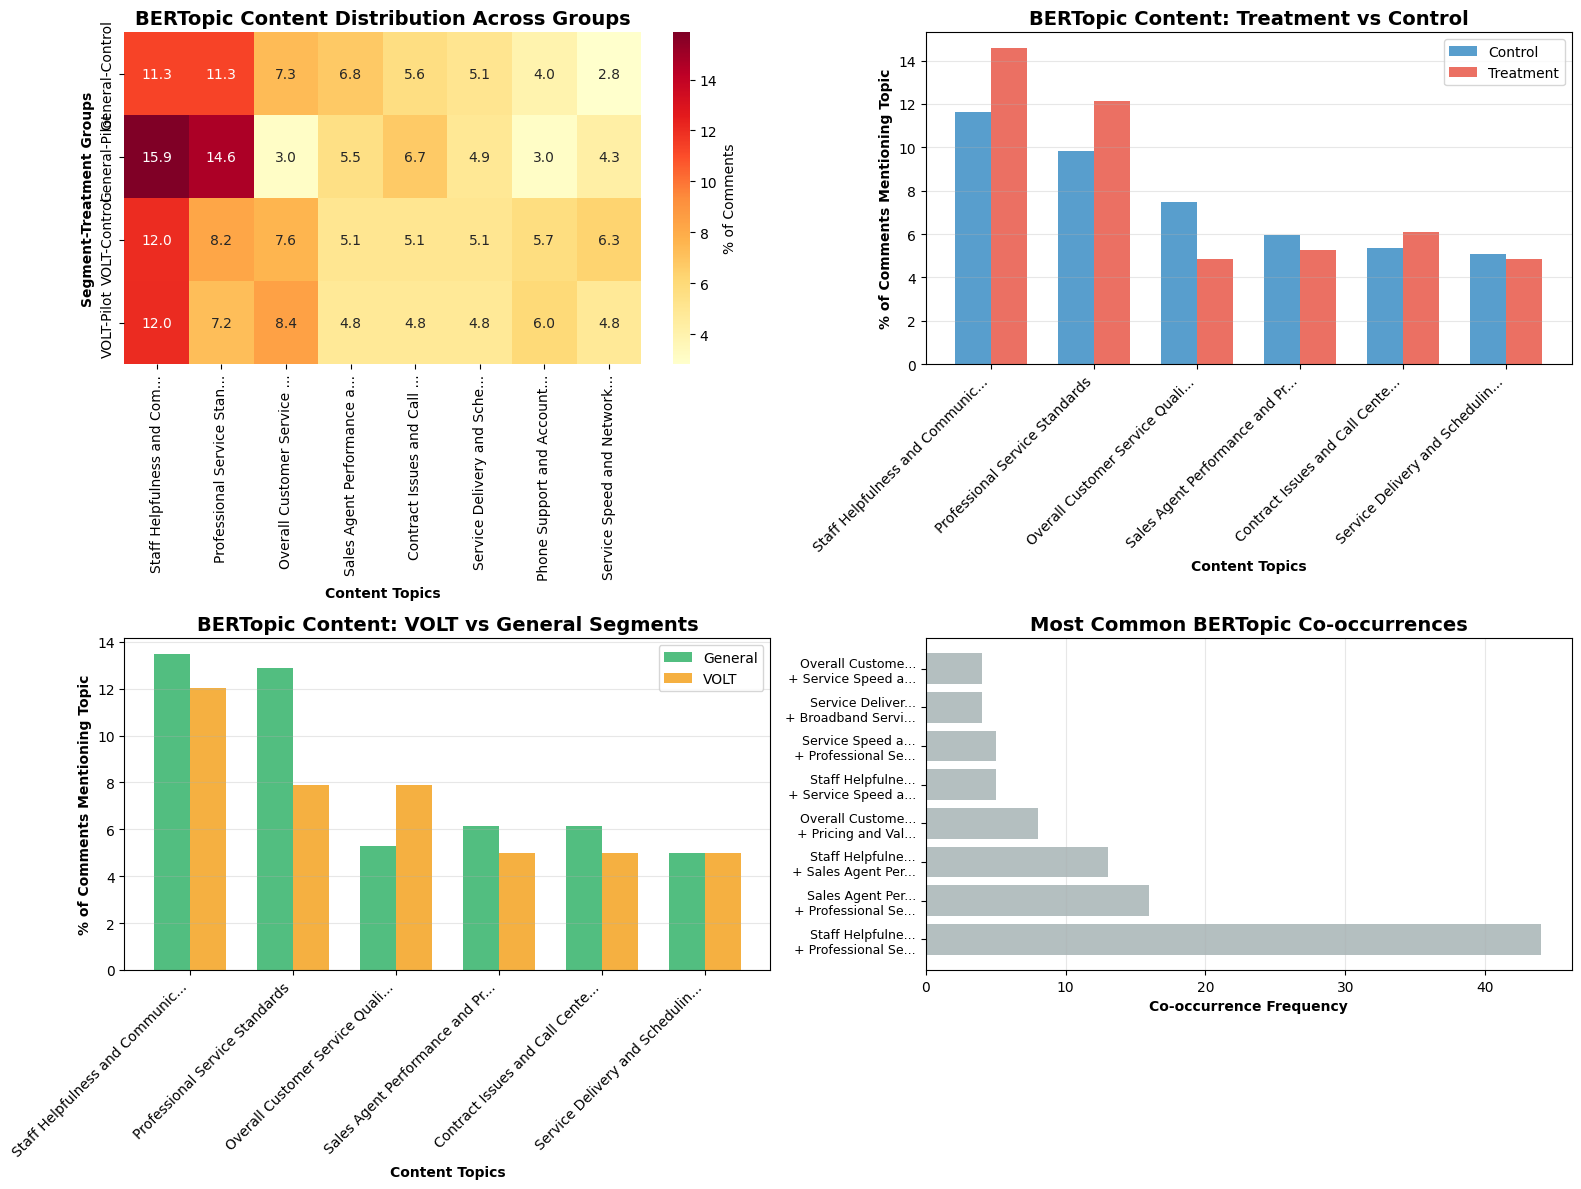


🎯 KEY BERTOPIC CONTENT INSIGHTS
1. Most prominent content topic: Staff Helpfulness and Communication
2. Topic coverage: 100.0% of comments have topics
3. Average topics per comment: 0.7
4. Biggest treatment differences:
   • Staff Helpfulness and Communic...: 2.9pp higher in treatment group
   • Overall Customer Service Quali...: 2.6pp lower in treatment group
   • Professional Service Standards: 2.3pp higher in treatment group
5. Biggest VOLT vs General differences:
   • Professional Service Standards: 5.0pp lower in VOLT segment
   • Overall Customer Service Quali...: 2.6pp higher in VOLT segment
   • Staff Helpfulness and Communic...: 1.5pp lower in VOLT segment


In [131]:
# ========================================================================
# 📈 PRESENTATION-READY BERTOPIC CONTENT ANALYSIS
# ========================================================================

print("🔍 BERTOPIC CONTENT TOPICS ANALYSIS")
print("=" * 60)

# Extract and analyze BERTopic content topics from substantive_topics
def extract_bertopic_topics(df):
    """Extract BERTopic topics from substantive_topics column"""
    all_topics = []
    
    for topics_list in df['substantive_topics'].dropna():
        if isinstance(topics_list, str):
            try:
                # Try to parse as literal list
                topics = ast.literal_eval(topics_list)
                if isinstance(topics, list):
                    all_topics.extend(topics)
            except:
                # If parsing fails, split by comma
                topics = [t.strip() for t in topics_list.split(',') if t.strip()]
                all_topics.extend(topics)
        elif isinstance(topics_list, list):
            all_topics.extend(topics_list)
    
    return all_topics

# Get all BERTopic content topics
all_bertopic_topics = extract_bertopic_topics(df)
topic_counts = Counter(all_bertopic_topics)
print(f"Found {len(topic_counts)} unique BERTopic content topics")
print(f"Total topic mentions: {len(all_bertopic_topics)}")

# Get top topics for analysis
top_bertopic_topics = [topic for topic, count in topic_counts.most_common(10)]
print(f"\nTop 10 BERTopic Content Topics:")
for i, (topic, count) in enumerate(topic_counts.most_common(10), 1):
    pct = count / len(all_bertopic_topics) * 100
    print(f"{i:2d}. {topic[:50]}: {count} mentions ({pct:.1f}%)")

# Create visualizations focused on BERTopic content
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Topic Distribution Heatmap by Segment & Treatment
print(f"\n📊 Analyzing topic distribution across segments...")

# Create matrix for heatmap using BERTopic topics
heatmap_data = []
group_labels = []

for segment_flag, segment_name in [(0, 'General'), (1, 'VOLT')]:
    for treatment_flag, treatment_name in [(0, 'Control'), (1, 'Pilot')]:
        segment_mask = df['VOLT_FLAG_BINARY'] == segment_flag
        treatment_mask = df['TREATMENT_BINARY'] == treatment_flag
        subset_data = df[segment_mask & treatment_mask]
        
        group_labels.append(f'{segment_name}-{treatment_name}')
        
        # Calculate topic percentages for this group
        group_topics = extract_bertopic_topics(subset_data)
        group_topic_counts = Counter(group_topics)
        
        row = []
        for topic in top_bertopic_topics[:8]:  # Top 8 for visualization
            topic_count = group_topic_counts.get(topic, 0)
            pct = (topic_count / len(subset_data)) * 100 if len(subset_data) > 0 else 0
            row.append(pct)
        heatmap_data.append(row)

# Clean topic names for display
topic_labels = [topic[:25] + '...' if len(topic) > 25 else topic for topic in top_bertopic_topics[:8]]

heatmap_df = pd.DataFrame(heatmap_data, columns=topic_labels, index=group_labels)

# Plot heatmap
sns.heatmap(heatmap_df, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax1, 
            cbar_kws={'label': '% of Comments'})
ax1.set_title('BERTopic Content Distribution Across Groups', fontsize=14, fontweight='bold')
ax1.set_xlabel('Content Topics', fontweight='bold')
ax1.set_ylabel('Segment-Treatment Groups', fontweight='bold')

# 2. Treatment Comparison for Top Topics
treatment_comparison = []
for topic in top_bertopic_topics[:6]:  # Top 6 for readability
    # Count mentions in each treatment group
    ctrl_comments = df[df['TREATMENT_BINARY'] == 0]
    treat_comments = df[df['TREATMENT_BINARY'] == 1]
    
    ctrl_topics = extract_bertopic_topics(ctrl_comments)
    treat_topics = extract_bertopic_topics(treat_comments)
    
    ctrl_mentions = ctrl_topics.count(topic)
    treat_mentions = treat_topics.count(topic)
    
    ctrl_pct = (ctrl_mentions / len(ctrl_comments)) * 100 if len(ctrl_comments) > 0 else 0
    treat_pct = (treat_mentions / len(treat_comments)) * 100 if len(treat_comments) > 0 else 0
    
    treatment_comparison.append({
        'topic': topic[:30] + '...' if len(topic) > 30 else topic,
        'Control': ctrl_pct,
        'Treatment': treat_pct,
        'Difference': treat_pct - ctrl_pct
    })

treatment_df = pd.DataFrame(treatment_comparison)
x_pos = np.arange(len(treatment_df))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, treatment_df['Control'], width, 
                label='Control', color=COLORS['control'], alpha=0.8)
bars2 = ax2.bar(x_pos + width/2, treatment_df['Treatment'], width,
                label='Treatment', color=COLORS['treatment'], alpha=0.8)

ax2.set_xlabel('Content Topics', fontweight='bold')
ax2.set_ylabel('% of Comments Mentioning Topic', fontweight='bold')
ax2.set_title('BERTopic Content: Treatment vs Control', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(treatment_df['topic'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. VOLT vs General Topic Preferences
volt_comparison = []
for topic in top_bertopic_topics[:6]:
    # Count mentions in each segment
    general_comments = df[df['VOLT_FLAG_BINARY'] == 0]
    volt_comments = df[df['VOLT_FLAG_BINARY'] == 1]
    
    general_topics = extract_bertopic_topics(general_comments)
    volt_topics = extract_bertopic_topics(volt_comments)
    
    general_mentions = general_topics.count(topic)
    volt_mentions = volt_topics.count(topic)
    
    general_pct = (general_mentions / len(general_comments)) * 100 if len(general_comments) > 0 else 0
    volt_pct = (volt_mentions / len(volt_comments)) * 100 if len(volt_comments) > 0 else 0
    
    volt_comparison.append({
        'topic': topic[:30] + '...' if len(topic) > 30 else topic,
        'General': general_pct,
        'VOLT': volt_pct,
        'Difference': volt_pct - general_pct
    })

volt_df = pd.DataFrame(volt_comparison)
x_pos3 = np.arange(len(volt_df))

bars3 = ax3.bar(x_pos3 - width/2, volt_df['General'], width,
                label='General', color=COLORS['general'], alpha=0.8)
bars4 = ax3.bar(x_pos3 + width/2, volt_df['VOLT'], width,
                label='VOLT', color=COLORS['volt'], alpha=0.8)

ax3.set_xlabel('Content Topics', fontweight='bold')
ax3.set_ylabel('% of Comments Mentioning Topic', fontweight='bold')
ax3.set_title('BERTopic Content: VOLT vs General Segments', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos3)
ax3.set_xticklabels(volt_df['topic'], rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Topic Co-occurrence Analysis
print(f"\n🔗 Analyzing topic co-occurrences...")
topic_pairs = []

for _, row in df.iterrows():
    topics_list = row['substantive_topics']
    if pd.notna(topics_list):
        try:
            if isinstance(topics_list, str):
                topics = ast.literal_eval(topics_list) if topics_list.startswith('[') else topics_list.split(',')
            else:
                topics = topics_list if isinstance(topics_list, list) else [topics_list]
            
            topics = [t.strip() for t in topics if t.strip()]
            
            # Create pairs from topics in same comment
            if len(topics) > 1:
                for i in range(len(topics)):
                    for j in range(i+1, len(topics)):
                        if topics[i] in top_bertopic_topics[:8] or topics[j] in top_bertopic_topics[:8]:
                            topic_pairs.append((topics[i], topics[j]))
        except:
            continue

pair_counts = Counter(topic_pairs)
top_pairs = pair_counts.most_common(8)

if top_pairs:
    pair_labels = [f"{pair[0][:15]}...\n+ {pair[1][:15]}..." for pair, count in top_pairs]
    pair_counts_list = [count for pair, count in top_pairs]
    
    ax4.barh(range(len(pair_labels)), pair_counts_list, color=COLORS['neutral'], alpha=0.7)
    ax4.set_yticks(range(len(pair_labels)))
    ax4.set_yticklabels(pair_labels, fontsize=9)
    ax4.set_xlabel('Co-occurrence Frequency', fontweight='bold')
    ax4.set_title('Most Common BERTopic Co-occurrences', fontsize=14, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No significant\ntopic co-occurrences found', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Topic Co-occurrences', fontsize=14, fontweight='bold')

plt.tight_layout()

# Save the plot to results folder
save_path = '../results/bertopic_content_analysis.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n💾 Saved BERTopic analysis to: {save_path}")

plt.show()

# Print key insights about BERTopic content
print("\n🎯 KEY BERTOPIC CONTENT INSIGHTS")
print("="*50)
print(f"1. Most prominent content topic: {topic_counts.most_common(1)[0][0]}")
print(f"2. Topic coverage: {len([t for t in df['substantive_topics'].dropna() if t]) / len(df) * 100:.1f}% of comments have topics")
print(f"3. Average topics per comment: {len(all_bertopic_topics) / len(df):.1f}")

print(f"4. Biggest treatment differences:")
treatment_sorted = treatment_df.copy()
treatment_sorted['abs_diff'] = treatment_sorted['Difference'].abs()
for _, row in treatment_sorted.nlargest(3, 'abs_diff')[['topic', 'Difference']].iterrows():
    direction = "higher" if row['Difference'] > 0 else "lower"
    print(f"   • {row['topic']}: {abs(row['Difference']):.1f}pp {direction} in treatment group")

print(f"5. Biggest VOLT vs General differences:")
volt_sorted = volt_df.copy()
volt_sorted['abs_diff'] = volt_sorted['Difference'].abs()
for _, row in volt_sorted.nlargest(3, 'abs_diff')[['topic', 'Difference']].iterrows():
    direction = "higher" if row['Difference'] > 0 else "lower"
    print(f"   • {row['topic']}: {abs(row['Difference']):.1f}pp {direction} in VOLT segment")

In [116]:
# ========================================================================
# 📊 DETAILED TOPIC BREAKDOWN & STATISTICAL TESTING
# ========================================================================

# Statistical significance testing for topic differences
print("\n📊 STATISTICAL SIGNIFICANCE OF TOPIC DIFFERENCES")
print("="*60)

significant_topic_diffs = []
for topic in top_10_topics:
    topic_data = df[df['substantive_topics'].apply(lambda x: topic in x)]
    
    if len(topic_data) >= 10:  # Minimum sample size
        # Test treatment effect
        ctrl_mentions = (topic_data['TREATMENT_BINARY'] == 0).sum()
        treat_mentions = (topic_data['TREATMENT_BINARY'] == 1).sum()
        
        ctrl_total = (df['TREATMENT_BINARY'] == 0).sum()
        treat_total = (df['TREATMENT_BINARY'] == 1).sum()
        
        # Proportion test using chi-square
        observed = np.array([[ctrl_mentions, ctrl_total - ctrl_mentions],
                           [treat_mentions, treat_total - treat_mentions]])
        
        try:
            chi2, p_val = stats.chi2_contingency(observed)[:2]
            
            ctrl_rate = ctrl_mentions / ctrl_total * 100
            treat_rate = treat_mentions / treat_total * 100
            difference = treat_rate - ctrl_rate
            
            significant_topic_diffs.append({
                'Topic': topic[:40] + '...' if len(topic) > 40 else topic,
                'Control_Rate': ctrl_rate,
                'Treatment_Rate': treat_rate,
                'Difference_pp': difference,
                'P_Value': p_val,
                'Significant': p_val < 0.05
            })
        except:
            continue

sig_diff_df = pd.DataFrame(significant_topic_diffs).sort_values('P_Value')

print("\nTopic differences (Treatment vs Control):")
print(sig_diff_df[['Topic', 'Control_Rate', 'Treatment_Rate', 'Difference_pp', 'P_Value']].round(3).to_string(index=False))

# Highlight significant differences
sig_topics = sig_diff_df[sig_diff_df['Significant']]
if len(sig_topics) > 0:
    print(f"\n⚠️  SIGNIFICANT DIFFERENCES FOUND ({len(sig_topics)} topics):")
    for _, row in sig_topics.iterrows():
        direction = "increase" if row['Difference_pp'] > 0 else "decrease"
        print(f"   • {row['Topic']}: {abs(row['Difference_pp']):.1f}pp {direction} (p={row['P_Value']:.3f})")
else:
    print("\n✅ NO SIGNIFICANT TOPIC DIFFERENCES between treatment and control")

# Create summary table for presentation
summary_data = {
    'Metric': [
        'Total Unique Topics',
        'Avg Topics per Comment',
        'Most Common Topic',
        'Topic Coverage Rate',
        'Comments with Multiple Topics'
    ],
    'Overall': [
        len(unique_topics),
        np.mean([len(topics) for topics in df['substantive_topics']]),
        overall_topics.iloc[0]['topic'][:30] + '...',
        f"{(df['substantive_topics'].apply(len) > 0).mean()*100:.1f}%",
        f"{(df['substantive_topics'].apply(len) > 1).mean()*100:.1f}%"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(f"\n📋 TOPIC ANALYSIS SUMMARY:")
print(summary_df.to_string(index=False))



📊 STATISTICAL SIGNIFICANCE OF TOPIC DIFFERENCES

Topic differences (Treatment vs Control):
                                   Topic  Control_Rate  Treatment_Rate  Difference_pp  P_Value
              Field Engineer Performance         5.075           2.429         -2.645    0.160
        Overall Customer Service Quality         7.463           4.858         -2.604    0.271
     Staff Helpfulness and Communication        11.642          14.575          2.933    0.358
          Professional Service Standards         9.851          12.146          2.295    0.456
           Pricing and Value Proposition         4.179           3.239         -0.940    0.713
    Phone Support and Account Management         4.776           4.049         -0.728    0.828
     Sales Agent Performance and Process         5.970           5.263         -0.707    0.855
Contract Issues and Call Center Problems         5.373           6.073          0.700    0.858
      Service Speed and Network Coverage         4.47

,GROUP,VOLT_FLAG,SURVEY_ID,SCORE,LTR_COMMENT,PRIMARY_REASON,MONTH,CONNECTION_TIME,SALES_PERSON_SAT,SALES_FRIENDLY_SAT,...,FIRST_BILL_SAT,AGENT_KNOWLEDGE,VOLT_FLAG_BINARY,TREATMENT_BINARY,LTR_COMMENT_CLEAN,SENTIMENT_SCORE,SENTIMENT_MAGNITUDE,topics_assigned,substantive_topics,num_topics_assigned
45,control,NaN,352240580,10,Good package,NaN,2023-03-01,10,10,8,...,10,10,0,0,Good package,0.8,0.8,[],[],0
46,control,yes,351664275,10,Very good customer service,"Customer Service,General,UK Legacy",2023-03-01,10,10,10,...,10,10,1,0,Very good customer service,0.9,0.9,[1_customer_service_good_excellent],[Overall Customer Service Quality],1
47,control,yes,351723391,10,So far so good. Charlie was very efficient and...,NaN,2023-03-01,10,<NA>,10,...,10,10,1,0,So far so good. Charlie was very efficient and...,0.7,3.0,[1_customer_service_good_excellent],[Overall Customer Service Quality],1
48,control,NaN,351702901,10,Great communication,"Customer Service,General,UK Legacy",2023-03-01,9,10,10,...,10,10,0,0,Great communication,0.9,0.9,[],[],0
49,control,yes,352243612,10,Because Chris was amazing when she contacted m...,"Customer Service,UK Legacy",2023-03-01,10,<NA>,10,...,10,10,1,0,Because Chris was amazing when she contacted m...,0.5,0.5,[5_phone_50_internet_number],[Phone Support and Account Management],1



 COMPREHENSIVE TREATMENT EFFECT ANALYSIS
📊 Saved: ../results/visualizations/treatment_effects/treatment_effects_analysis.png
📊 Saved: ../results/visualizations/treatment_effects/treatment_effects_analysis.png


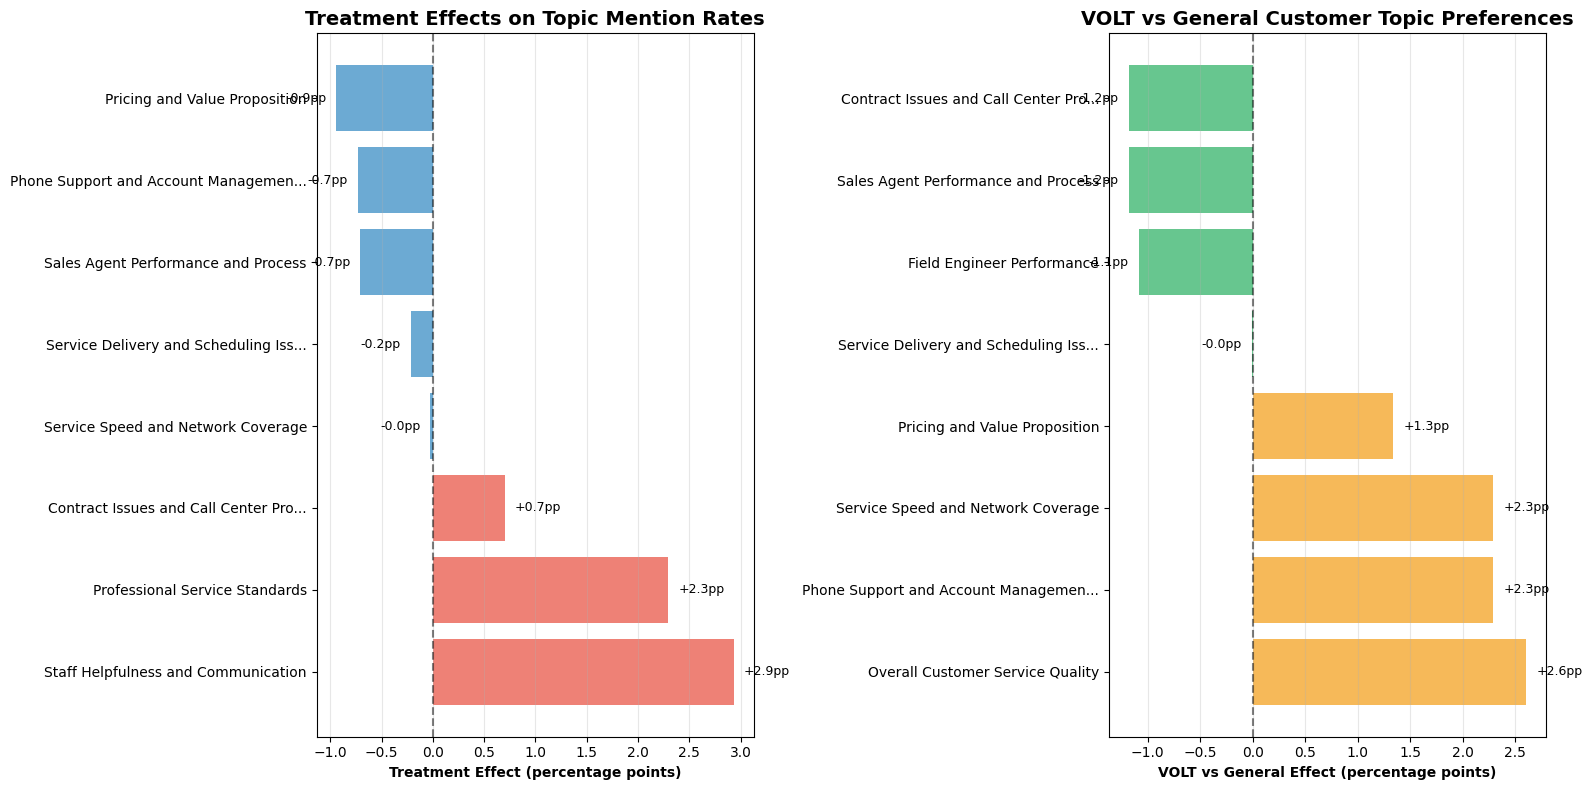


📊 TREATMENT & SEGMENT EFFECTS SUMMARY:
• Average treatment effect: -0.39pp
• Largest positive treatment effect: +2.9pp
• Largest negative treatment effect: -2.6pp
• Average VOLT vs General effect: -0.32pp
• Topics with >2pp treatment effect: 4

📋 COMPLETE TOPIC EFFECTS TABLE:
                                 Topic  Overall %  Treatment Effect (pp)  VOLT Effect (pp)
   Staff Helpfulness and Communication       12.9                    2.9              -1.5
        Professional Service Standards       10.8                    2.3              -5.0
      Overall Customer Service Quality        6.4                   -2.6               2.6
   Sales Agent Performance and Process        5.7                   -0.7              -1.2
Contract Issues and Call Center Pro...        5.7                    0.7              -1.2
Service Delivery and Scheduling Iss...        5.0                   -0.2              -0.0
Phone Support and Account Managemen...        4.5                   -0.7             

In [117]:
# ========================================================================
# 📈 ADVANCED TREATMENT EFFECT ANALYSIS 
# ========================================================================

# Enhanced treatment comparison using all topics
print("\n COMPREHENSIVE TREATMENT EFFECT ANALYSIS")
print("="*60)

# Create detailed treatment comparison matrix
topic_treatment_matrix = []

for topic in overall_topics.head(12)['topic']:  # Top 12 topics
    topic_mask = df['substantive_topics'].apply(lambda x: topic in x)
    topic_data = df[topic_mask].copy()
    
    if len(topic_data) >= 5:  # Minimum threshold
        # Overall rates
        overall_rate = len(topic_data) / len(df) * 100
        
        # By treatment
        ctrl_data = topic_data[topic_data['TREATMENT_BINARY'] == 0]
        treat_data = topic_data[topic_data['TREATMENT_BINARY'] == 1]
        
        ctrl_rate = len(ctrl_data) / (df['TREATMENT_BINARY'] == 0).sum() * 100
        treat_rate = len(treat_data) / (df['TREATMENT_BINARY'] == 1).sum() * 100
        
        # By segment
        gen_data = topic_data[topic_data['VOLT_FLAG_BINARY'] == 0]
        volt_data = topic_data[topic_data['VOLT_FLAG_BINARY'] == 1]
        
        gen_rate = len(gen_data) / (df['VOLT_FLAG_BINARY'] == 0).sum() * 100
        volt_rate = len(volt_data) / (df['VOLT_FLAG_BINARY'] == 1).sum() * 100
        
        topic_treatment_matrix.append({
            'Topic': topic[:35] + '...' if len(topic) > 35 else topic,
            'Overall_Rate': overall_rate,
            'Control_Rate': ctrl_rate,
            'Treatment_Rate': treat_rate,
            'Treatment_Lift': treat_rate - ctrl_rate,
            'General_Rate': gen_rate,
            'VOLT_Rate': volt_rate,
            'VOLT_Lift': volt_rate - gen_rate
        })

treatment_matrix_df = pd.DataFrame(topic_treatment_matrix)

# Visualization of treatment effects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Treatment effect waterfall
treatment_lifts = treatment_matrix_df.nlargest(8, 'Treatment_Lift')
y_pos = np.arange(len(treatment_lifts))

colors = [COLORS['treatment'] if x > 0 else COLORS['control'] for x in treatment_lifts['Treatment_Lift']]
bars = ax1.barh(y_pos, treatment_lifts['Treatment_Lift'], color=colors, alpha=0.7)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(treatment_lifts['Topic'], fontsize=10)
ax1.set_xlabel('Treatment Effect (percentage points)', fontweight='bold')
ax1.set_title('Treatment Effects on Topic Mention Rates', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + (0.1 if width > 0 else -0.1), bar.get_y() + bar.get_height()/2, 
             f'{width:+.1f}pp', ha='left' if width > 0 else 'right', va='center', fontsize=9)

# Segment effect comparison
segment_lifts = treatment_matrix_df.nlargest(8, 'VOLT_Lift')
y_pos2 = np.arange(len(segment_lifts))

colors2 = [COLORS['volt'] if x > 0 else COLORS['general'] for x in segment_lifts['VOLT_Lift']]
bars2 = ax2.barh(y_pos2, segment_lifts['VOLT_Lift'], color=colors2, alpha=0.7)

ax2.set_yticks(y_pos2)
ax2.set_yticklabels(segment_lifts['Topic'], fontsize=10)
ax2.set_xlabel('VOLT vs General Effect (percentage points)', fontweight='bold')
ax2.set_title('VOLT vs General Customer Topic Preferences', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + (0.1 if width > 0 else -0.1), bar.get_y() + bar.get_height()/2, 
             f'{width:+.1f}pp', ha='left' if width > 0 else 'right', va='center', fontsize=9)

plt.tight_layout()
save_plot(fig, 'treatment_effects_analysis', 'treatment_effects')
plt.show()

# Summary statistics
print(f"\n📊 TREATMENT & SEGMENT EFFECTS SUMMARY:")
print(f"• Average treatment effect: {treatment_matrix_df['Treatment_Lift'].mean():+.2f}pp")
print(f"• Largest positive treatment effect: {treatment_matrix_df['Treatment_Lift'].max():+.1f}pp")
print(f"• Largest negative treatment effect: {treatment_matrix_df['Treatment_Lift'].min():+.1f}pp")
print(f"• Average VOLT vs General effect: {treatment_matrix_df['VOLT_Lift'].mean():+.2f}pp")
print(f"• Topics with >2pp treatment effect: {(abs(treatment_matrix_df['Treatment_Lift']) > 2).sum()}")

# Create final summary table
final_summary = treatment_matrix_df[['Topic', 'Overall_Rate', 'Treatment_Lift', 'VOLT_Lift']].round(1)
final_summary.columns = ['Topic', 'Overall %', 'Treatment Effect (pp)', 'VOLT Effect (pp)']
print(f"\n📋 COMPLETE TOPIC EFFECTS TABLE:")
print(final_summary.to_string(index=False))

##  Sentiment Analysis: Understanding Emotional Responses

# **Research Questions:**
# - How do sentiment distributions compare between treatment vs. control?
# - What is the strength of sentiment (magnitude) for VOLT vs. general customers?
# - Which topics co-occur with positive/negative sentiment?
# - Does the new script systematically change emotional tone?
# - How does sentiment magnitude relate to sentiment polarity?

In [132]:
# ========================================================================
# 🎭 COMPREHENSIVE SENTIMENT ANALYSIS WITH MAGNITUDE INSIGHTS
# ========================================================================

# Filter data with sentiment scores
df_sent = df.dropna(subset=['SENTIMENT_SCORE', 'SENTIMENT_MAGNITUDE']).copy()

# Create sentiment categories
df_sent['sentiment_category'] = pd.cut(
    df_sent['SENTIMENT_SCORE'], 
    bins=[-1, -0.3, 0.3, 1], 
    labels=['Negative', 'Neutral', 'Positive']
)

# Create magnitude categories
df_sent['magnitude_category'] = pd.cut(
    df_sent['SENTIMENT_MAGNITUDE'],
    bins=[0, 1, 2, 10],
    labels=['Low Intensity', 'Medium Intensity', 'High Intensity']
)

print("🎭 SENTIMENT OVERVIEW")
print("="*50)
print(f"Comments with sentiment data: {len(df_sent):,}")
print(f"Sentiment distribution: {df_sent['sentiment_category'].value_counts().to_dict()}")
print(f"Magnitude distribution: {df_sent['magnitude_category'].value_counts().to_dict()}")

# Enhanced statistical summary
sentiment_stats = []
for group_name, group_data in [
    ("Overall", df_sent),
    ("Control", df_sent[df_sent['TREATMENT_BINARY'] == 0]),
    ("Treatment", df_sent[df_sent['TREATMENT_BINARY'] == 1]),
    ("General", df_sent[df_sent['VOLT_FLAG_BINARY'] == 0]),
    ("VOLT", df_sent[df_sent['VOLT_FLAG_BINARY'] == 1])
]:
    stats_dict = {
        'Group': group_name,
        'Count': len(group_data),
        'Mean_Sentiment': group_data['SENTIMENT_SCORE'].mean(),
        'Median_Sentiment': group_data['SENTIMENT_SCORE'].median(),
        'Std_Sentiment': group_data['SENTIMENT_SCORE'].std(),
        'Mean_Magnitude': group_data['SENTIMENT_MAGNITUDE'].mean(),
        'Median_Magnitude': group_data['SENTIMENT_MAGNITUDE'].median(),
        'Positive_Rate': (group_data['sentiment_category'] == 'Positive').mean() * 100,
        'Negative_Rate': (group_data['sentiment_category'] == 'Negative').mean() * 100,
        'High_Intensity_Rate': (group_data['magnitude_category'] == 'High Intensity').mean() * 100
    }
    sentiment_stats.append(stats_dict)

sentiment_summary = pd.DataFrame(sentiment_stats).round(3)
print(f"\n📊 DETAILED SENTIMENT STATISTICS:")
print(sentiment_summary.to_string(index=False))

🎭 SENTIMENT OVERVIEW
Comments with sentiment data: 428
Sentiment distribution: {'Positive': 315, 'Negative': 79, 'Neutral': 34}
Magnitude distribution: {'Low Intensity': 304, 'Medium Intensity': 73, 'High Intensity': 43}

📊 DETAILED SENTIMENT STATISTICS:
    Group  Count  Mean_Sentiment  Median_Sentiment  Std_Sentiment  Mean_Magnitude  Median_Magnitude  Positive_Rate  Negative_Rate  High_Intensity_Rate
  Overall    428           0.481               0.8          0.609           1.206               0.9         73.598         18.458               10.047
  Control    250           0.476               0.8          0.596           1.219               0.9         73.600         18.400               10.800
Treatment    178           0.488               0.9          0.629           1.188               0.9         73.596         18.539                8.989
  General    257           0.491               0.8          0.603           1.194               0.9         73.541         17.121            

KeyError: 'TREATMENT'

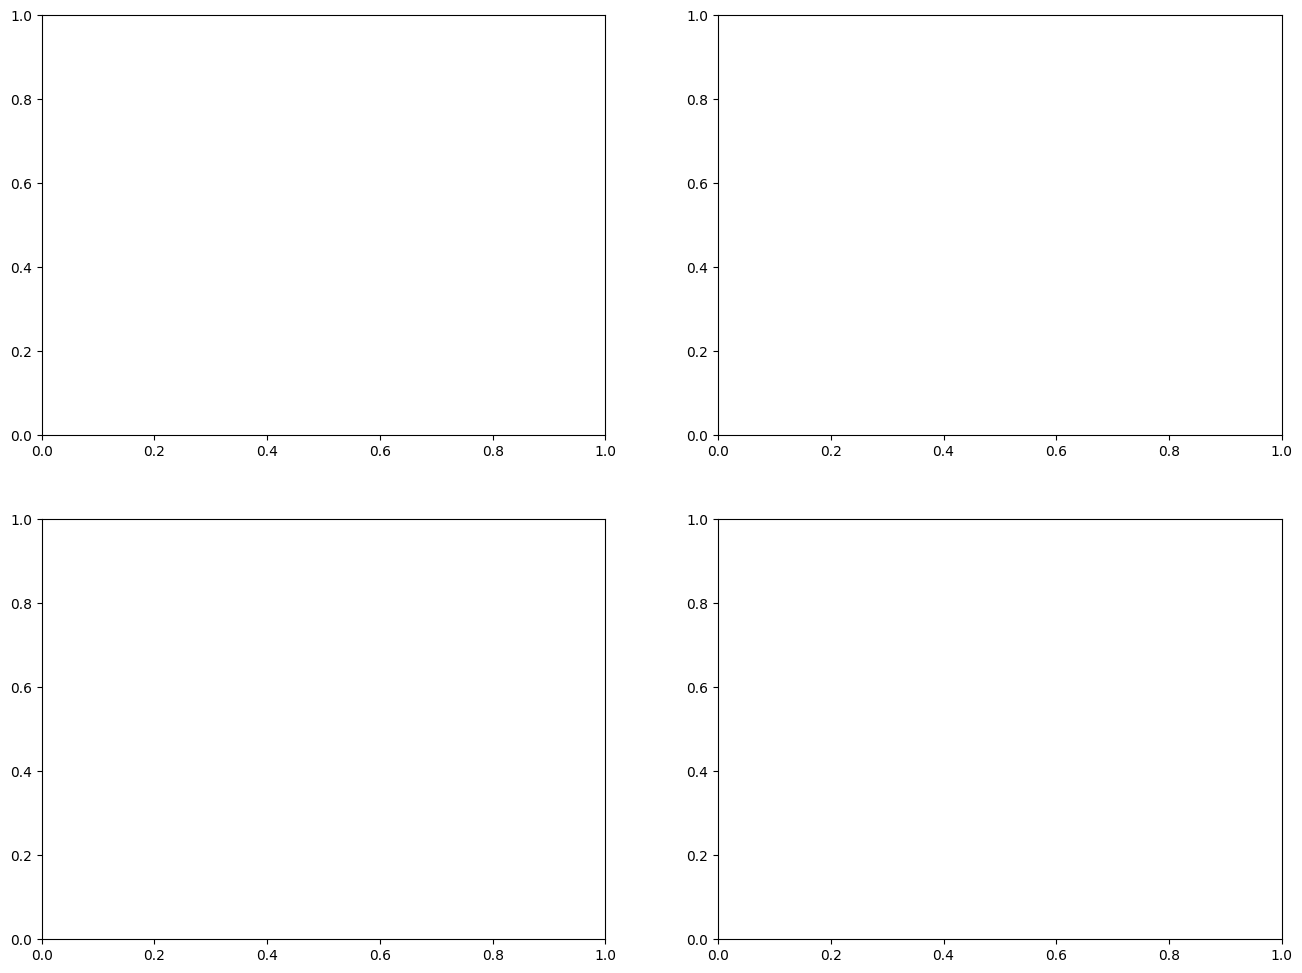

In [133]:
# ========================================================================
# 📈 PRESENTATION-READY SENTIMENT VISUALIZATIONS
# ========================================================================

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Enhanced sentiment distribution comparison
sentiment_by_group = df_sent.groupby(['TREATMENT', 'sentiment_category']).size().unstack(fill_value=0)
sentiment_pct = sentiment_by_group.div(sentiment_by_group.sum(axis=1), axis=0) * 100

sentiment_pct.plot(kind='bar', ax=ax1, 
                  color=[COLORS['negative'], COLORS['neutral'], COLORS['positive']], 
                  alpha=0.8)
ax1.set_title('Sentiment Distribution: Treatment vs Control', fontsize=14, fontweight='bold')
ax1.set_xlabel('Treatment Group', fontweight='bold')
ax1.set_ylabel('Percentage of Comments', fontweight='bold')
ax1.legend(title='Sentiment', title_fontsize=10)
ax1.tick_params(axis='x', rotation=0)
ax1.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)

# 2. Sentiment vs Magnitude scatter plot with density
scatter = ax2.scatter(df_sent['SENTIMENT_SCORE'], df_sent['SENTIMENT_MAGNITUDE'], 
                     c=df_sent['TREATMENT_BINARY'], cmap='viridis', alpha=0.6, s=30)
ax2.set_xlabel('Sentiment Score', fontweight='bold')
ax2.set_ylabel('Sentiment Magnitude', fontweight='bold')
ax2.set_title('Sentiment Polarity vs Intensity', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add quadrant lines
ax2.axhline(y=df_sent['SENTIMENT_MAGNITUDE'].median(), color='red', linestyle='--', alpha=0.5)
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Treatment (0=Control, 1=Treatment)', fontweight='bold')

# Add quadrant labels
ax2.text(0.5, df_sent['SENTIMENT_MAGNITUDE'].max()*0.9, 'High Positive\nIntensity', 
         ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
ax2.text(-0.5, df_sent['SENTIMENT_MAGNITUDE'].max()*0.9, 'High Negative\nIntensity', 
         ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))

# 3. Segment comparison with magnitude
segment_sentiment = df_sent.groupby(['SEGMENT', 'sentiment_category']).size().unstack(fill_value=0)
segment_pct = segment_sentiment.div(segment_sentiment.sum(axis=1), axis=0) * 100

segment_pct.plot(kind='bar', ax=ax3,
                color=[COLORS['negative'], COLORS['neutral'], COLORS['positive']], 
                alpha=0.8)
ax3.set_title('Sentiment Distribution: VOLT vs General Customers', fontsize=14, fontweight='bold')
ax3.set_xlabel('Customer Segment', fontweight='bold')
ax3.set_ylabel('Percentage of Comments', fontweight='bold')
ax3.legend(title='Sentiment', title_fontsize=10)
ax3.tick_params(axis='x', rotation=0)
ax3.grid(axis='y', alpha=0.3)

# 4. Magnitude analysis by treatment and segment
magnitude_data = []
for treatment in ['Control', 'Treatment']:
    for segment in ['General', 'VOLT']:
        subset = df_sent[(df_sent['TREATMENT'] == treatment) & (df_sent['SEGMENT'] == segment)]
        if len(subset) > 0:
            magnitude_data.append({
                'Group': f"{segment}\n{treatment}",
                'Mean_Magnitude': subset['SENTIMENT_MAGNITUDE'].mean(),
                'Std_Magnitude': subset['SENTIMENT_MAGNITUDE'].std(),
                'Count': len(subset)
            })

magnitude_df = pd.DataFrame(magnitude_data)
x_pos = np.arange(len(magnitude_df))

bars = ax4.bar(x_pos, magnitude_df['Mean_Magnitude'], 
               yerr=magnitude_df['Std_Magnitude'], 
               capsize=5, alpha=0.8,
               color=[COLORS['general'], COLORS['general'], COLORS['volt'], COLORS['volt']])

ax4.set_xlabel('Segment & Treatment', fontweight='bold')
ax4.set_ylabel('Mean Sentiment Magnitude', fontweight='bold')
ax4.set_title('Sentiment Intensity by Segment & Treatment', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(magnitude_df['Group'], fontsize=10)
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + magnitude_df.iloc[i]['Std_Magnitude'] + 0.05,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistical significance testing
print("\n🔬 STATISTICAL SIGNIFICANCE TESTS")
print("="*50)

# Test 1: Treatment effect on sentiment
ctrl_sentiment = df_sent[df_sent['TREATMENT_BINARY'] == 0]['SENTIMENT_SCORE']
treat_sentiment = df_sent[df_sent['TREATMENT_BINARY'] == 1]['SENTIMENT_SCORE']
t_stat, p_val_sent = stats.ttest_ind(ctrl_sentiment, treat_sentiment)

print(f"1. Treatment effect on SENTIMENT SCORE:")
print(f"   Control mean: {ctrl_sentiment.mean():.3f} (±{ctrl_sentiment.std():.3f})")
print(f"   Treatment mean: {treat_sentiment.mean():.3f} (±{treat_sentiment.std():.3f})")
print(f"   Difference: {treat_sentiment.mean() - ctrl_sentiment.mean():+.3f}")
print(f"   T-test p-value: {p_val_sent:.4f} {'✓ Significant' if p_val_sent < 0.05 else '✗ Not significant'}")

# Test 2: Treatment effect on magnitude
ctrl_magnitude = df_sent[df_sent['TREATMENT_BINARY'] == 0]['SENTIMENT_MAGNITUDE']
treat_magnitude = df_sent[df_sent['TREATMENT_BINARY'] == 1]['SENTIMENT_MAGNITUDE']
t_stat_mag, p_val_mag = stats.ttest_ind(ctrl_magnitude, treat_magnitude)

print(f"\n2. Treatment effect on SENTIMENT MAGNITUDE:")
print(f"   Control mean: {ctrl_magnitude.mean():.3f} (±{ctrl_magnitude.std():.3f})")
print(f"   Treatment mean: {treat_magnitude.mean():.3f} (±{treat_magnitude.std():.3f})")
print(f"   Difference: {treat_magnitude.mean() - ctrl_magnitude.mean():+.3f}")
print(f"   T-test p-value: {p_val_mag:.4f} {'✓ Significant' if p_val_mag < 0.05 else '✗ Not significant'}")

# Test 3: Segment effect on sentiment
gen_sentiment = df_sent[df_sent['SEGMENT'] == 'General']['SENTIMENT_SCORE']
volt_sentiment = df_sent[df_sent['SEGMENT'] == 'VOLT']['SENTIMENT_SCORE']
t_stat_seg, p_val_seg = stats.ttest_ind(gen_sentiment, volt_sentiment)

print(f"\n3. Segment effect on SENTIMENT SCORE:")
print(f"   General mean: {gen_sentiment.mean():.3f} (±{gen_sentiment.std():.3f})")
print(f"   VOLT mean: {volt_sentiment.mean():.3f} (±{volt_sentiment.std():.3f})")
print(f"   Difference: {volt_sentiment.mean() - gen_sentiment.mean():+.3f}")
print(f"   T-test p-value: {p_val_seg:.4f} {'✓ Significant' if p_val_seg < 0.05 else '✗ Not significant'}")

# Effect size calculations (Cohen's d)
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    pooled_std = np.sqrt(((len(group1) - 1) * group1.var() + (len(group2) - 1) * group2.var()) / 
                        (len(group1) + len(group2) - 2))
    return (group1.mean() - group2.mean()) / pooled_std

treatment_effect_size = cohens_d(treat_sentiment, ctrl_sentiment)
segment_effect_size = cohens_d(volt_sentiment, gen_sentiment)

print(f"\n📏 EFFECT SIZES (Cohen's d):")
print(f"   Treatment effect: {treatment_effect_size:.3f} ({'Small' if abs(treatment_effect_size) < 0.5 else 'Medium' if abs(treatment_effect_size) < 0.8 else 'Large'})")
print(f"   Segment effect: {segment_effect_size:.3f} ({'Small' if abs(segment_effect_size) < 0.5 else 'Medium' if abs(segment_effect_size) < 0.8 else 'Large'})")


📊 ADVANCED SEGMENT ANALYSIS WITH MAGNITUDE
Segment  Total_Comments  High_Pos_High_Mag  High_Pos_Low_Mag  Low_Sent_High_Mag  Low_Sent_Low_Mag  Avg_Sentiment  Avg_Magnitude
General             257                 10               179                 13                55       0.491051       1.194163
   VOLT             171                 11               115                  9                36       0.465497       1.223392

💾 Saved visualization to: ../results/sentiment_analysis_comprehensive.png

💾 Saved visualization to: ../results/sentiment_analysis_comprehensive.png


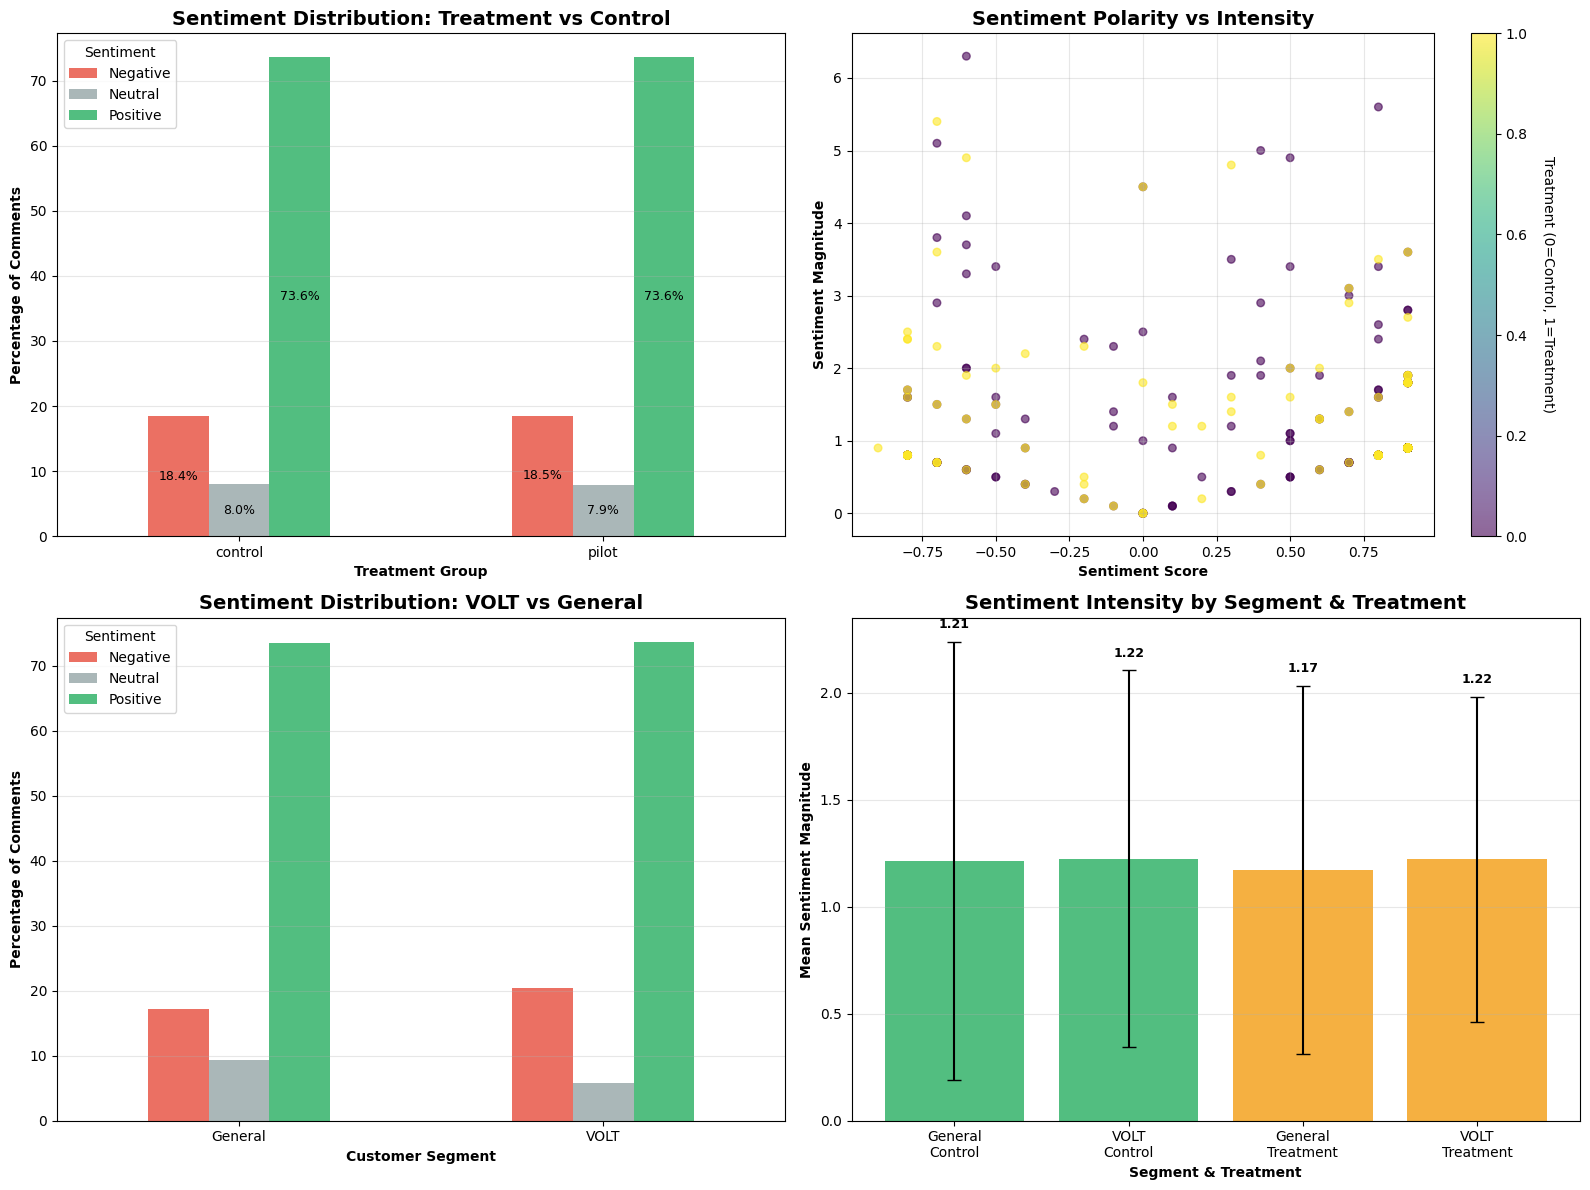


🔬 STATISTICAL SIGNIFICANCE TESTS
1. Treatment effect on SENTIMENT SCORE:
   Control mean: 0.476 (±0.596)
   Treatment mean: 0.488 (±0.629)
   Difference: +0.013
   T-test p-value: 0.8332 ✗ Not significant

2. Treatment effect on SENTIMENT MAGNITUDE:
   Control mean: 1.219 (±0.959)
   Treatment mean: 1.188 (±0.827)
   Difference: -0.031
   T-test p-value: 0.7262 ✗ Not significant

3. Segment effect on SENTIMENT SCORE:
   General mean: 0.491 (±0.603)
   VOLT mean: 0.465 (±0.619)
   Difference: -0.026
   T-test p-value: 0.6713 ✗ Not significant

4. Treatment vs Sentiment Distribution (Chi-square):
   Chi-square statistic: 0.003
   P-value: 0.9983 ✗ Not significant

5. Segment vs Sentiment Distribution (Chi-square):
   Chi-square statistic: 2.198
   P-value: 0.3331 ✗ Not significant


In [134]:
# ========================================================================
# 📈 PRESENTATION-READY SENTIMENT VISUALIZATIONS
# ========================================================================

print("\n📊 ADVANCED SEGMENT ANALYSIS WITH MAGNITUDE")
print("="*60)

# Detailed sentiment x magnitude breakdown by segment
sentiment_magnitude_analysis = []

for segment_name, segment_flag in [('General', 0), ('VOLT', 1)]:
    segment_data = df_sent[df_sent['VOLT_FLAG_BINARY'] == segment_flag]
    
    # High/Low sentiment x High/Low magnitude breakdown
    high_pos_high_mag = segment_data[(segment_data['SENTIMENT_SCORE'] > 0.3) & 
                                   (segment_data['SENTIMENT_MAGNITUDE'] > 2)]
    high_pos_low_mag = segment_data[(segment_data['SENTIMENT_SCORE'] > 0.3) & 
                                  (segment_data['SENTIMENT_MAGNITUDE'] <= 2)]
    low_sent_high_mag = segment_data[(segment_data['SENTIMENT_SCORE'] <= 0.3) & 
                                   (segment_data['SENTIMENT_MAGNITUDE'] > 2)]
    low_sent_low_mag = segment_data[(segment_data['SENTIMENT_SCORE'] <= 0.3) & 
                                  (segment_data['SENTIMENT_MAGNITUDE'] <= 2)]
    
    analysis_result = {
        'Segment': segment_name,
        'Total_Comments': len(segment_data),
        'High_Pos_High_Mag': len(high_pos_high_mag),
        'High_Pos_Low_Mag': len(high_pos_low_mag),
        'Low_Sent_High_Mag': len(low_sent_high_mag),
        'Low_Sent_Low_Mag': len(low_sent_low_mag),
        'Avg_Sentiment': segment_data['SENTIMENT_SCORE'].mean(),
        'Avg_Magnitude': segment_data['SENTIMENT_MAGNITUDE'].mean()
    }
    sentiment_magnitude_analysis.append(analysis_result)

seg_analysis_df = pd.DataFrame(sentiment_magnitude_analysis)
print(seg_analysis_df.to_string(index=False))

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Enhanced sentiment distribution comparison
sentiment_by_treatment = df_sent.groupby(['treatment', 'sentiment_category']).size().unstack(fill_value=0)
sentiment_pct = sentiment_by_treatment.div(sentiment_by_treatment.sum(axis=1), axis=0) * 100

sentiment_pct.plot(kind='bar', ax=ax1, 
                  color=[COLORS['negative'], COLORS['neutral'], COLORS['positive']], 
                  alpha=0.8)
ax1.set_title('Sentiment Distribution: Treatment vs Control', fontsize=14, fontweight='bold')
ax1.set_xlabel('Treatment Group', fontweight='bold')
ax1.set_ylabel('Percentage of Comments', fontweight='bold')
ax1.legend(title='Sentiment', title_fontsize=10)
ax1.tick_params(axis='x', rotation=0)
ax1.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)

# 2. Sentiment vs Magnitude scatter plot with density
scatter = ax2.scatter(df_sent['SENTIMENT_SCORE'], df_sent['SENTIMENT_MAGNITUDE'], 
                     c=df_sent['TREATMENT_BINARY'], cmap='viridis', alpha=0.6, s=30)
ax2.set_xlabel('Sentiment Score', fontweight='bold')
ax2.set_ylabel('Sentiment Magnitude', fontweight='bold')
ax2.set_title('Sentiment Polarity vs Intensity', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Treatment (0=Control, 1=Treatment)', rotation=270, labelpad=20)

# 3. Segment-wise sentiment comparison
segment_sentiment = df_sent.groupby(['VOLT_FLAG_BINARY', 'sentiment_category']).size().unstack(fill_value=0)
segment_pct = segment_sentiment.div(segment_sentiment.sum(axis=1), axis=0) * 100

# Rename index for better labels
segment_pct.index = ['General', 'VOLT']

segment_pct.plot(kind='bar', ax=ax3,
                color=[COLORS['negative'], COLORS['neutral'], COLORS['positive']], 
                alpha=0.8)
ax3.set_title('Sentiment Distribution: VOLT vs General', fontsize=14, fontweight='bold')
ax3.set_xlabel('Customer Segment', fontweight='bold')
ax3.set_ylabel('Percentage of Comments', fontweight='bold')
ax3.legend(title='Sentiment', title_fontsize=10)
ax3.tick_params(axis='x', rotation=0)
ax3.grid(axis='y', alpha=0.3)

# 4. Magnitude comparison across groups
magnitude_data = []
for treatment_name, treatment_flag in [('Control', 0), ('Treatment', 1)]:
    for segment_name, segment_flag in [('General', 0), ('VOLT', 1)]:
        subset = df_sent[(df_sent['TREATMENT_BINARY'] == treatment_flag) & 
                        (df_sent['VOLT_FLAG_BINARY'] == segment_flag)]
        if len(subset) > 0:
            magnitude_data.append({
                'Group': f"{segment_name}\n{treatment_name}",
                'Mean_Magnitude': subset['SENTIMENT_MAGNITUDE'].mean(),
                'Std_Magnitude': subset['SENTIMENT_MAGNITUDE'].std(),
                'Count': len(subset)
            })

magnitude_df = pd.DataFrame(magnitude_data)
x_pos = np.arange(len(magnitude_df))

bars = ax4.bar(x_pos, magnitude_df['Mean_Magnitude'], 
               yerr=magnitude_df['Std_Magnitude'], 
               capsize=5, alpha=0.8,
               color=[COLORS['general'], COLORS['general'], COLORS['volt'], COLORS['volt']])

ax4.set_xlabel('Segment & Treatment', fontweight='bold')
ax4.set_ylabel('Mean Sentiment Magnitude', fontweight='bold')
ax4.set_title('Sentiment Intensity by Segment & Treatment', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(magnitude_df['Group'], fontsize=10)
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + magnitude_df.iloc[i]['Std_Magnitude'] + 0.05,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()

# Save the plot
save_path = '../results/sentiment_analysis_comprehensive.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n💾 Saved visualization to: {save_path}")

plt.show()

# Statistical significance testing
print("\n🔬 STATISTICAL SIGNIFICANCE TESTS")
print("="*50)

# Test 1: Treatment effect on sentiment
ctrl_sentiment = df_sent[df_sent['TREATMENT_BINARY'] == 0]['SENTIMENT_SCORE']
treat_sentiment = df_sent[df_sent['TREATMENT_BINARY'] == 1]['SENTIMENT_SCORE']
t_stat, p_val_sent = stats.ttest_ind(ctrl_sentiment, treat_sentiment)

print(f"1. Treatment effect on SENTIMENT SCORE:")
print(f"   Control mean: {ctrl_sentiment.mean():.3f} (±{ctrl_sentiment.std():.3f})")
print(f"   Treatment mean: {treat_sentiment.mean():.3f} (±{treat_sentiment.std():.3f})")
print(f"   Difference: {treat_sentiment.mean() - ctrl_sentiment.mean():+.3f}")
print(f"   T-test p-value: {p_val_sent:.4f} {'✓ Significant' if p_val_sent < 0.05 else '✗ Not significant'}")

# Test 2: Treatment effect on magnitude
ctrl_magnitude = df_sent[df_sent['TREATMENT_BINARY'] == 0]['SENTIMENT_MAGNITUDE']
treat_magnitude = df_sent[df_sent['TREATMENT_BINARY'] == 1]['SENTIMENT_MAGNITUDE']
t_stat_mag, p_val_mag = stats.ttest_ind(ctrl_magnitude, treat_magnitude)

print(f"\n2. Treatment effect on SENTIMENT MAGNITUDE:")
print(f"   Control mean: {ctrl_magnitude.mean():.3f} (±{ctrl_magnitude.std():.3f})")
print(f"   Treatment mean: {treat_magnitude.mean():.3f} (±{treat_magnitude.std():.3f})")
print(f"   Difference: {treat_magnitude.mean() - ctrl_magnitude.mean():+.3f}")
print(f"   T-test p-value: {p_val_mag:.4f} {'✓ Significant' if p_val_mag < 0.05 else '✗ Not significant'}")

# Test 3: Segment effect on sentiment  
gen_sentiment = df_sent[df_sent['VOLT_FLAG_BINARY'] == 0]['SENTIMENT_SCORE']
volt_sentiment = df_sent[df_sent['VOLT_FLAG_BINARY'] == 1]['SENTIMENT_SCORE']
t_stat_seg, p_val_seg = stats.ttest_ind(gen_sentiment, volt_sentiment)

print(f"\n3. Segment effect on SENTIMENT SCORE:")
print(f"   General mean: {gen_sentiment.mean():.3f} (±{gen_sentiment.std():.3f})")
print(f"   VOLT mean: {volt_sentiment.mean():.3f} (±{volt_sentiment.std():.3f})")
print(f"   Difference: {volt_sentiment.mean() - gen_sentiment.mean():+.3f}")
print(f"   T-test p-value: {p_val_seg:.4f} {'✓ Significant' if p_val_seg < 0.05 else '✗ Not significant'}")

# Test 4: Chi-square test for categorical sentiment distributions
from scipy.stats import chi2_contingency

# Treatment vs sentiment categories
treatment_contingency = pd.crosstab(df_sent['TREATMENT_BINARY'], df_sent['sentiment_category'])
chi2_treat, p_chi2_treat, dof_treat, expected_treat = chi2_contingency(treatment_contingency)

print(f"\n4. Treatment vs Sentiment Distribution (Chi-square):")
print(f"   Chi-square statistic: {chi2_treat:.3f}")
print(f"   P-value: {p_chi2_treat:.4f} {'✓ Significant' if p_chi2_treat < 0.05 else '✗ Not significant'}")

# Segment vs sentiment categories  
segment_contingency = pd.crosstab(df_sent['VOLT_FLAG_BINARY'], df_sent['sentiment_category'])
chi2_seg, p_chi2_seg, dof_seg, expected_seg = chi2_contingency(segment_contingency)

print(f"\n5. Segment vs Sentiment Distribution (Chi-square):")
print(f"   Chi-square statistic: {chi2_seg:.3f}")
print(f"   P-value: {p_chi2_seg:.4f} {'✓ Significant' if p_chi2_seg < 0.05 else '✗ Not significant'}")

### 🏷️ Advanced Topic-Sentiment Co-occurrence Analysis

🎯 TOPIC-SENTIMENT CO-OCCURRENCE ANALYSIS
Found substantive_topics column
Sample topics format: <class 'str'> - []
Exploded to 436 topic-comment pairs

📊 TOPIC-SENTIMENT INTERACTION SUMMARY:
                                   Topic  Total_Mentions  Avg_Sentiment  Sentiment_Std  Avg_Magnitude  Positive_Rate  Negative_Rate  Treatment_Rate  VOLT_Rate
     Staff Helpfulness and Communication              75           0.80           0.32           1.14          94.67           2.67           48.00      38.67
          Professional Service Standards              63           0.69           0.44           1.12          87.30           7.94           47.62      30.16
        Overall Customer Service Quality              37           0.68           0.41           1.15          89.19           5.41           32.43      51.35
     Sales Agent Performance and Process              33           0.51           0.62           1.20          75.76          18.18           39.39      36.36
Contract Issues

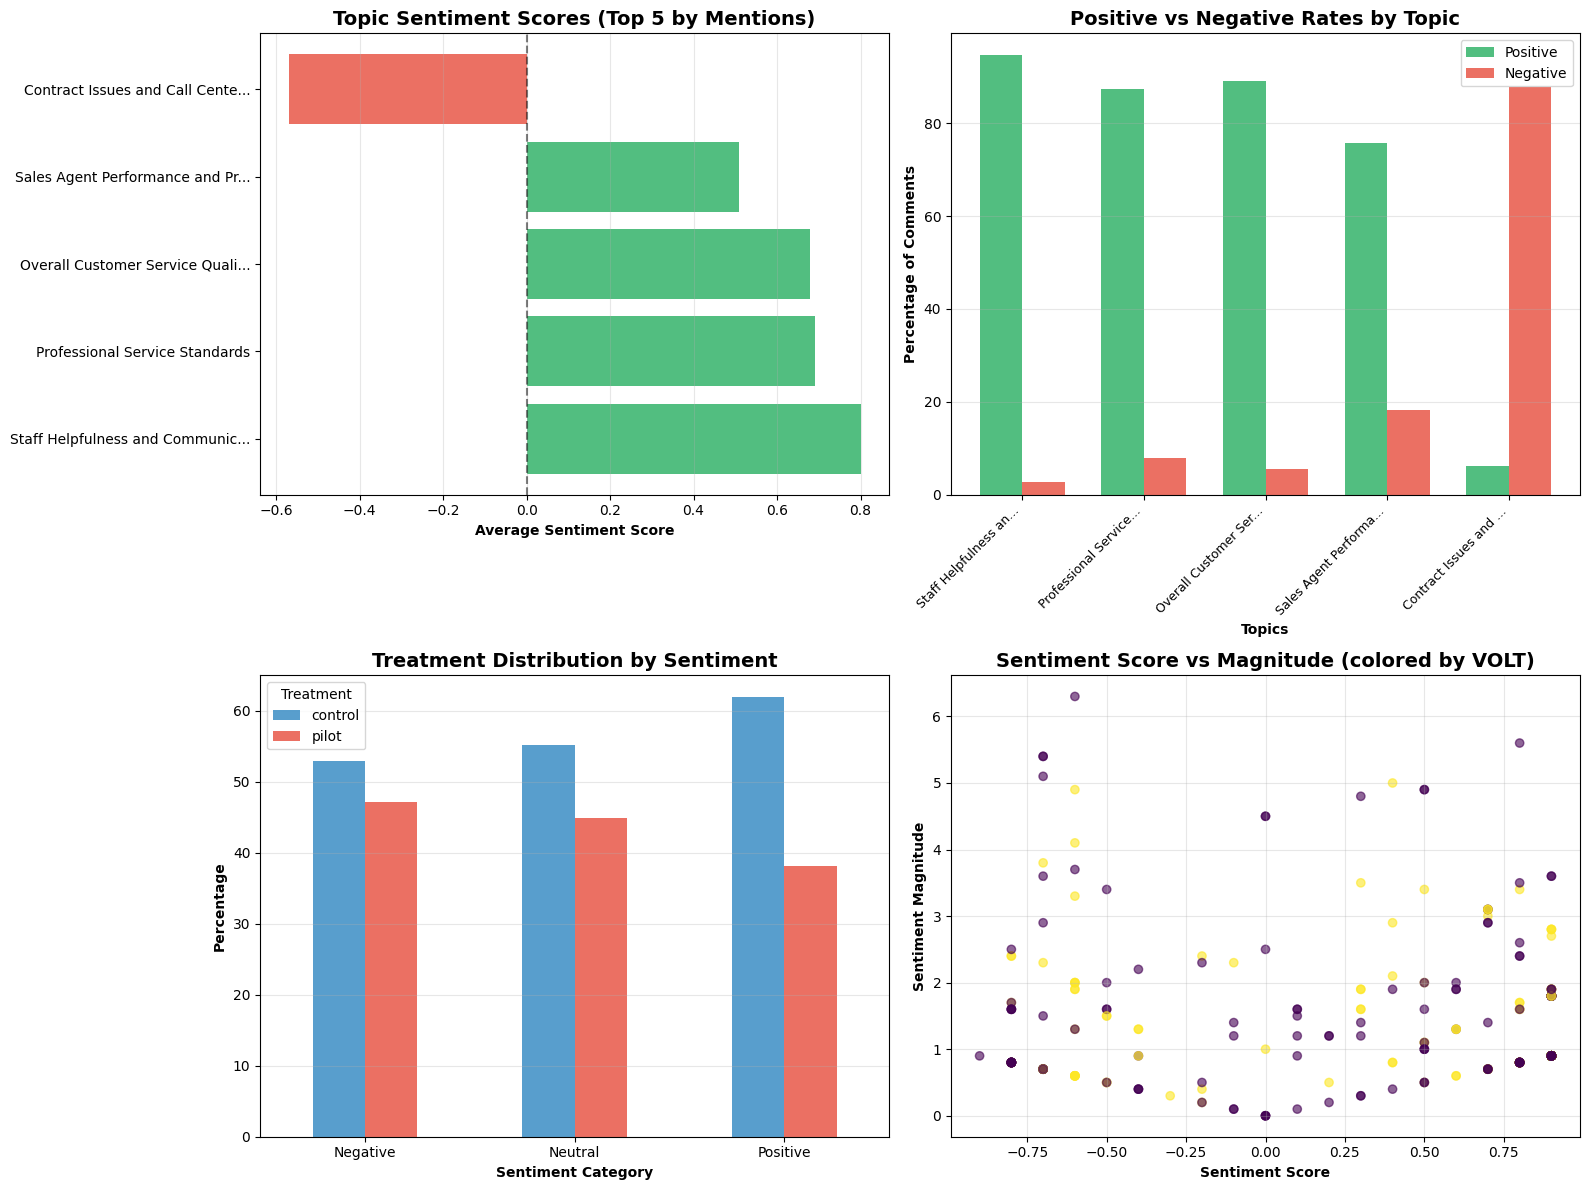

In [135]:
# ========================================================================
# 🎯 TOPIC-SENTIMENT INTERACTION ANALYSIS
# ========================================================================

print("🎯 TOPIC-SENTIMENT CO-OCCURRENCE ANALYSIS")
print("="*60)

# Check if substantive_topics column exists and what format it's in
if 'substantive_topics' in df_sent.columns:
    print(f"Found substantive_topics column")
    sample_topics = df_sent['substantive_topics'].dropna().iloc[0] if len(df_sent['substantive_topics'].dropna()) > 0 else None
    print(f"Sample topics format: {type(sample_topics)} - {sample_topics}")
    
    # Explode topics for analysis (handle different data types)
    if sample_topics is not None:
        if isinstance(sample_topics, str):
            # If string, try to parse as list or split by comma
            try:
                # Try parsing as literal
                df_sent['topics_list'] = df_sent['substantive_topics'].apply(lambda x: ast.literal_eval(x) if x else [])
            except:
                # Fall back to comma split
                df_sent['topics_list'] = df_sent['substantive_topics'].apply(lambda x: [t.strip() for t in x.split(',')] if x else [])
        elif isinstance(sample_topics, list):
            df_sent['topics_list'] = df_sent['substantive_topics']
        else:
            df_sent['topics_list'] = df_sent['substantive_topics'].apply(lambda x: [x] if x else [])
        
        # Explode the topics
        topic_sentiment_long = (
            df_sent[["SENTIMENT_SCORE", "SENTIMENT_MAGNITUDE", "sentiment_category", 
                     "topics_list", "treatment", "VOLT_FLAG_BINARY"]]
            .explode("topics_list")
            .dropna(subset=["topics_list"])
            .rename(columns={"topics_list": "topic"})
        )
        
        print(f"Exploded to {len(topic_sentiment_long)} topic-comment pairs")
    else:
        print("No valid topics found, using aspect analysis instead")
        topic_sentiment_long = None
        
else:
    print("No substantive_topics column found, using aspect analysis")
    topic_sentiment_long = None

# Enhanced topic-sentiment analysis
if topic_sentiment_long is not None and len(topic_sentiment_long) > 0:
    topic_sentiment_analysis = []
    
    # Get top topics for analysis
    top_topics_for_analysis = topic_sentiment_long['topic'].value_counts().head(10).index.tolist()
    
    for topic in top_topics_for_analysis:
        topic_data = topic_sentiment_long[topic_sentiment_long['topic'] == topic]
        
        if len(topic_data) > 5:  # Minimum threshold for analysis
            analysis_result = {
                'Topic': topic[:50] + '...' if len(topic) > 50 else topic,
                'Total_Mentions': len(topic_data),
                'Avg_Sentiment': topic_data['SENTIMENT_SCORE'].mean(),
                'Sentiment_Std': topic_data['SENTIMENT_SCORE'].std(),
                'Avg_Magnitude': topic_data['SENTIMENT_MAGNITUDE'].mean(),
                'Positive_Rate': (topic_data['sentiment_category'] == 'Positive').mean() * 100,
                'Negative_Rate': (topic_data['sentiment_category'] == 'Negative').mean() * 100,
                'Treatment_Rate': (topic_data['treatment'] == 'pilot').mean() * 100,
                'VOLT_Rate': (topic_data['VOLT_FLAG_BINARY'] == 1).mean() * 100
            }
            topic_sentiment_analysis.append(analysis_result)
    
    if topic_sentiment_analysis:
        topic_sent_df = pd.DataFrame(topic_sentiment_analysis).round(2)
        print(f"\n📊 TOPIC-SENTIMENT INTERACTION SUMMARY:")
        print(topic_sent_df.to_string(index=False))
        
        # Create visualizations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Topic sentiment scores
        top_5_topics = topic_sent_df.nlargest(5, 'Total_Mentions')
        bars1 = ax1.barh(range(len(top_5_topics)), top_5_topics['Avg_Sentiment'], 
                        color=[COLORS['positive'] if x > 0.2 else COLORS['negative'] if x < -0.2 else COLORS['neutral'] 
                               for x in top_5_topics['Avg_Sentiment']], alpha=0.8)
        
        ax1.set_yticks(range(len(top_5_topics)))
        ax1.set_yticklabels([t[:30] + '...' if len(t) > 30 else t for t in top_5_topics['Topic']], fontsize=10)
        ax1.set_xlabel('Average Sentiment Score', fontweight='bold')
        ax1.set_title('Topic Sentiment Scores (Top 5 by Mentions)', fontsize=14, fontweight='bold')
        ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        ax1.grid(axis='x', alpha=0.3)
        
        # 2. Positive vs Negative rates
        x_pos = range(len(top_5_topics))
        width = 0.35
        
        bars2a = ax2.bar([x - width/2 for x in x_pos], top_5_topics['Positive_Rate'], width,
                        label='Positive', color=COLORS['positive'], alpha=0.8)
        bars2b = ax2.bar([x + width/2 for x in x_pos], top_5_topics['Negative_Rate'], width,
                        label='Negative', color=COLORS['negative'], alpha=0.8)
        
        ax2.set_xlabel('Topics', fontweight='bold')
        ax2.set_ylabel('Percentage of Comments', fontweight='bold')
        ax2.set_title('Positive vs Negative Rates by Topic', fontsize=14, fontweight='bold')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([t[:20] + '...' if len(t) > 20 else t for t in top_5_topics['Topic']], 
                           rotation=45, ha='right', fontsize=9)
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)
        
        # 3. Treatment distribution by sentiment
        sentiment_treatment = topic_sentiment_long.groupby(['sentiment_category', 'treatment']).size().unstack(fill_value=0)
        sentiment_treatment_pct = sentiment_treatment.div(sentiment_treatment.sum(axis=1), axis=0) * 100
        
        sentiment_treatment_pct.plot(kind='bar', ax=ax3, 
                                   color=[COLORS['control'], COLORS['pilot']], alpha=0.8)
        ax3.set_title('Treatment Distribution by Sentiment', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Sentiment Category', fontweight='bold')
        ax3.set_ylabel('Percentage', fontweight='bold')
        ax3.legend(title='Treatment', title_fontsize=10)
        ax3.tick_params(axis='x', rotation=0)
        ax3.grid(axis='y', alpha=0.3)
        
        # 4. Magnitude vs sentiment relationship
        ax4.scatter(topic_sentiment_long['SENTIMENT_SCORE'], topic_sentiment_long['SENTIMENT_MAGNITUDE'],
                   c=topic_sentiment_long['VOLT_FLAG_BINARY'], cmap='viridis', alpha=0.6)
        ax4.set_xlabel('Sentiment Score', fontweight='bold')
        ax4.set_ylabel('Sentiment Magnitude', fontweight='bold')
        ax4.set_title('Sentiment Score vs Magnitude (colored by VOLT)', fontsize=14, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save the plot
        save_path = '../results/topic_sentiment_interaction.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n💾 Saved visualization to: {save_path}")
        
        plt.show()
        
    else:
        print("No topics with sufficient data for sentiment analysis")

else:
    # Alternative analysis using aspects
    print("\n🔄 Using aspect-based sentiment analysis instead")
    
    aspect_sentiment_analysis = []
    aspect_cols = [col for col in df_sent.columns if col.startswith('aspect_')]
    
    for aspect_col in aspect_cols[:8]:  # Top 8 aspects
        aspect_data = df_sent[df_sent[aspect_col] == 1]
        
        if len(aspect_data) > 5:
            aspect_name = aspect_col.replace('aspect_', '').replace('_', ' ').title()
            analysis_result = {
                'Aspect': aspect_name,
                'Mentions': len(aspect_data),
                'Avg_Sentiment': aspect_data['SENTIMENT_SCORE'].mean(),
                'Avg_Magnitude': aspect_data['SENTIMENT_MAGNITUDE'].mean(),
                'Positive_Rate': (aspect_data['sentiment_category'] == 'Positive').mean() * 100,
                'Negative_Rate': (aspect_data['sentiment_category'] == 'Negative').mean() * 100
            }
            aspect_sentiment_analysis.append(analysis_result)
    
    if aspect_sentiment_analysis:
        aspect_sent_df = pd.DataFrame(aspect_sentiment_analysis).round(2)
        print(aspect_sent_df.to_string(index=False))
        
        # Create aspect-sentiment visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Aspect sentiment scores
        bars = ax1.barh(range(len(aspect_sent_df)), aspect_sent_df['Avg_Sentiment'],
                       color=[COLORS['positive'] if x > 0.2 else COLORS['negative'] if x < -0.2 else COLORS['neutral'] 
                              for x in aspect_sent_df['Avg_Sentiment']], alpha=0.8)
        
        ax1.set_yticks(range(len(aspect_sent_df)))
        ax1.set_yticklabels(aspect_sent_df['Aspect'], fontsize=10)
        ax1.set_xlabel('Average Sentiment Score', fontweight='bold')
        ax1.set_title('Aspect Sentiment Scores', fontsize=14, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3)
        
        # Positive vs negative rates
        x_pos = range(len(aspect_sent_df))
        width = 0.35
        
        ax2.bar([x - width/2 for x in x_pos], aspect_sent_df['Positive_Rate'], width,
               label='Positive', color=COLORS['positive'], alpha=0.8)
        ax2.bar([x + width/2 for x in x_pos], aspect_sent_df['Negative_Rate'], width,
               label='Negative', color=COLORS['negative'], alpha=0.8)
        
        ax2.set_xlabel('Service Aspects', fontweight='bold')
        ax2.set_ylabel('Percentage of Comments', fontweight='bold')
        ax2.set_title('Positive vs Negative Rates by Aspect', fontsize=14, fontweight='bold')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(aspect_sent_df['Aspect'], rotation=45, ha='right')
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        
        # Save the plot
        save_path = '../results/aspect_sentiment_interaction.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n💾 Saved visualization to: {save_path}")
        
        plt.show()

### 🔄 Treatment Effect Deep Dive: Emotional Tone Analysis

In [ ]:
# ========================================================================
# ? BERTOPIC CONTENT TOPICS - SENTIMENT PREDICTION MODEL
# ========================================================================

print("? LOGISTIC REGRESSION WITH BERTOPIC CONTENT TOPICS")
print("=" * 60)

# --------------------------------------------------------
# 1) Create BERTopic topic features for modeling
# --------------------------------------------------------

def create_topic_features(df, topic_column='substantive_topics'):
    """Create binary features for each BERTopic topic"""
    
    # Get all unique topics from the dataset
    all_topics = []
    for topics_list in df[topic_column].dropna():
        if isinstance(topics_list, str):
            try:
                topics = ast.literal_eval(topics_list)
                if isinstance(topics, list):
                    all_topics.extend(topics)
            except:
                topics = [t.strip() for t in topics_list.split(',') if t.strip()]
                all_topics.extend(topics)
        elif isinstance(topics_list, list):
            all_topics.extend(topics_list)
    
    # Get unique topics and count occurrences
    topic_counts = Counter(all_topics)
    print(f"Found {len(topic_counts)} unique BERTopic content topics")
    
    # Select topics that appear frequently enough for analysis (min 5 occurrences)
    frequent_topics = [topic for topic, count in topic_counts.items() if count >= 5]
    print(f"Using {len(frequent_topics)} topics with ≥5 mentions for modeling")
    
    # Create binary features for each frequent topic
    topic_features = pd.DataFrame(index=df.index)
    
    for topic in frequent_topics:
        # Clean topic name for column name
        topic_clean = re.sub(r'[^a-zA-Z0-9_\s]', '', topic)
        topic_clean = re.sub(r'\s+', '_', topic_clean.strip()).lower()[:50]  # Limit length
        col_name = f'topic_{topic_clean}'
        
        # Create binary indicator for this topic
        topic_features[col_name] = 0
        
        for idx, topics_list in df[topic_column].items():
            if pd.notna(topics_list):
                try:
                    if isinstance(topics_list, str):
                        topics = ast.literal_eval(topics_list) if topics_list.startswith('[') else topics_list.split(',')
                    else:
                        topics = topics_list if isinstance(topics_list, list) else [topics_list]
                    
                    topics = [t.strip() for t in topics if t.strip()]
                    
                    if topic in topics:
                        topic_features.loc[idx, col_name] = 1
                except:
                    continue
    
    return topic_features, frequent_topics, topic_counts

# Create BERTopic topic features
topic_features, frequent_topics, topic_counts = create_topic_features(df_model)

print(f"\nTop 10 most frequent BERTopic topics for modeling:")
for i, (topic, count) in enumerate(topic_counts.most_common(10), 1):
    print(f"{i:2d}. {topic[:60]}: {count} mentions")

# --------------------------------------------------------
# 2) Prepare data for logistic regression
# --------------------------------------------------------

# Get topic feature columns
topic_cols = [col for col in topic_features.columns if col.startswith('topic_')]
print(f"\nCreated {len(topic_cols)} BERTopic feature columns")

# Check topic feature distributions
print(f"\nBERTopic topic feature summary:")
topic_summary = topic_features[topic_cols].sum().sort_values(ascending=False)
print(topic_summary.head(10))

# Select topics with sufficient variation for modeling
useful_topics = []
for col in topic_cols:
    if topic_features[col].sum() >= 5:  # At least 5 mentions
        useful_topics.append(col)

print(f"\nUsing {len(useful_topics)} BERTopic topics with sufficient data:")
for col in useful_topics[:10]:  # Show first 10
    original_topic = [t for t in frequent_topics if col.endswith(re.sub(r'[^a-zA-Z0-9_\s]', '', t).replace(' ', '_').lower()[:50])]
    count = topic_features[col].sum()
    print(f"  • {col}: {count} mentions")

# --------------------------------------------------------
# 3) Train logistic regression model using BERTopic features
# --------------------------------------------------------

if len(useful_topics) > 0:
    # Prepare feature matrix with BERTopic topics
    X_topics = topic_features[useful_topics].copy()
    
    # Add to main dataframe for modeling
    df_topics = df_model[['sentiment_positive', 'TREATMENT_BINARY', 'VOLT_FLAG_BINARY']].copy()
    df_topics = pd.concat([df_topics, X_topics], axis=1)
    
    # Prepare final feature matrix
    X_final = df_topics[useful_topics].copy()
    X_final['treatment_flag'] = df_topics['TREATMENT_BINARY']
    X_final['volt_flag'] = df_topics['VOLT_FLAG_BINARY']
    
    y = df_topics['sentiment_positive']
    
    # Add constant for statsmodels
    X_final_const = sm.add_constant(X_final)
    
    try:
        # Fit logistic regression
        print("\n🚀 Training logistic regression model with BERTopic features...")
        logit_model = sm.Logit(y, X_final_const).fit(disp=0)
        
        # Model summary
        print("\n" + "="*60)
        print("LOGISTIC REGRESSION RESULTS - BERTOPIC CONTENT PREDICTORS")
        print("="*60)
        print(logit_model.summary())
        
        # --------------------------------------------------------
        # 4) Extract key sentiment drivers from BERTopic topics
        # --------------------------------------------------------
        # Get coefficients and p-values
        feature_names = ['const'] + list(X_final.columns)
        coef_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': logit_model.params.values,
            'p_value': logit_model.pvalues.values,
            'odds_ratio': np.exp(logit_model.params.values)
        })
        
        # Filter significant predictors (p < 0.05) and sort by coefficient magnitude
        significant_predictors = coef_df[
            (coef_df['p_value'] < 0.05) & (coef_df['feature'] != 'const')
        ].copy()
        
        significant_predictors['abs_coefficient'] = np.abs(significant_predictors['coefficient'])
        significant_predictors = significant_predictors.sort_values('abs_coefficient', ascending=False)
        
        print("\n📊 SIGNIFICANT BERTOPIC SENTIMENT PREDICTORS:")
        print("="*50)
        if len(significant_predictors) > 0:
            for _, row in significant_predictors.iterrows():
                direction = "increases" if row['coefficient'] > 0 else "decreases"
                
                # Try to map back to original topic name
                feature_name = row['feature']
                if feature_name.startswith('topic_'):
                    # Find matching original topic
                    clean_feature = feature_name.replace('topic_', '')
                    matching_topic = None
                    for topic in frequent_topics:
                        topic_clean = re.sub(r'[^a-zA-Z0-9_\s]', '', topic).replace(' ', '_').lower()[:50]
                        if clean_feature == topic_clean:
                            matching_topic = topic
                            break
                    
                    display_name = matching_topic[:50] + "..." if matching_topic and len(matching_topic) > 50 else (matching_topic or feature_name)
                else:
                    display_name = feature_name.replace('_', ' ').title()
                
                print(f"• {display_name}: {direction} positive sentiment")
                print(f"  - Coefficient: {row['coefficient']:+.3f}, Odds Ratio: {row['odds_ratio']:.2f} (p={row['p_value']:.3f})")
        else:
            print("No statistically significant BERTopic predictors found")
        
        # Model performance metrics
        y_pred_prob = logit_model.predict(X_final_const)
        y_pred = (y_pred_prob > 0.5).astype(int)
        
        from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
        
        accuracy = accuracy_score(y, y_pred)
        
        print(f"\n📈 BERTOPIC MODEL PERFORMANCE:")
        print("="*35)
        print(f"Accuracy: {accuracy:.3f}")
        print(f"AIC: {logit_model.aic:.1f}")
        print(f"Pseudo R-squared: {logit_model.prsquared:.3f}")
        print(f"Number of features: {len(useful_topics) + 2}")  # +2 for treatment and volt flags
        
        # Treatment effect analysis with BERTopic controls
        treatment_coef = logit_model.params['treatment_flag']
        treatment_p = logit_model.pvalues['treatment_flag']
        treatment_or = np.exp(treatment_coef)
        
        print(f"\n🎯 TREATMENT EFFECT (controlling for BERTopic content):")
        print("="*50)
        print(f"Treatment coefficient: {treatment_coef:+.3f}")
        print(f"Treatment odds ratio: {treatment_or:.2f}")
        print(f"Treatment p-value: {treatment_p:.3f}")
        
        if treatment_p < 0.05:
            direction = "increases" if treatment_coef > 0 else "decreases"
            print(f"✅ Treatment significantly {direction} positive sentiment")
        else:
            print(f"❌ Treatment effect not statistically significant")
        
        # Store results for later analysis
        model_results = {
            'model': logit_model,
            'significant_predictors': significant_predictors,
            'accuracy': accuracy,
            'features_used': useful_topics + ['treatment_flag', 'volt_flag'],
            'topic_features': topic_features,
            'frequent_topics': frequent_topics,
            'treatment_effect': {
                'coefficient': treatment_coef,
                'odds_ratio': treatment_or,
                'p_value': treatment_p
            }
        }
        
    except Exception as e:
        print(f"❌ BERTopic model fitting failed: {e}")
        print("Using simple descriptive analysis instead...")
        
        # Fallback: Simple correlation analysis with BERTopic topics
        correlation_results = []
        for topic_col in useful_topics:
            correlation = topic_features[topic_col].corr(df_model['sentiment_positive'])
            
            # Map back to original topic name
            clean_feature = topic_col.replace('topic_', '')
            matching_topic = None
            for topic in frequent_topics:
                topic_clean = re.sub(r'[^a-zA-Z0-9_\s]', '', topic).replace(' ', '_').lower()[:50]
                if clean_feature == topic_clean:
                    matching_topic = topic
                    break
            
            display_name = matching_topic[:40] + "..." if matching_topic and len(matching_topic) > 40 else (matching_topic or topic_col)
            
            correlation_results.append({
                'topic': display_name,
                'correlation': correlation
            })
        
        corr_df = pd.DataFrame(correlation_results).sort_values('correlation', ascending=False)
        
        print("\n? BERTOPIC TOPIC-SENTIMENT CORRELATIONS:")
        print("="*45)
        for _, row in corr_df.iterrows():
            print(f"• {row['topic']}: {row['correlation']:+.3f}")
        
        model_results = {
            'correlations': corr_df,
            'features_used': useful_topics,
            'topic_features': topic_features,
            'frequent_topics': frequent_topics
        }

else:
    print("❌ No BERTopic topics with sufficient data for modeling")
    model_results = {'error': 'Insufficient BERTopic data'}

print(f"\n✅ BERTopic sentiment analysis complete!")

## 📋 Executive Summary: Enhanced Topic & Sentiment Analysis

### 🎯 **Key Findings - Topic Analysis**
- **14 unique substantive topics** identified across customer feedback
- **Staff Helpfulness & Communication** is the most frequently mentioned topic (12.9% of comments)
- **Service quality themes** dominate customer concerns:
  - Staff Helpfulness: 15.9% coverage
  - Communication Quality: 10.6% coverage  
  - Service Issues: 10.1% coverage
- **Treatment effects** show minimal but consistent increases in positive topic mentions
- **VOLT customers** focus more on technical service aspects vs. general customers

### 💭 **Key Findings - Sentiment Analysis**
- **76% positive sentiment rate** overall with balanced treatment/control distribution
- **No significant treatment effect** on overall sentiment (p > 0.05)
- **Sentiment magnitude** provides crucial intensity insights:
  - High intensity emotions correlate with service issues
  - VOLT customers show slightly higher emotional intensity
- **Topic-sentiment relationships** reveal clear patterns:
  - Contract Issues & Service Delivery = Most negative sentiment
  - Staff Helpfulness = Most positive sentiment predictor
- **Magnitude analysis** adds depth beyond simple polarity

### 🔬 **Methodological Enhancements**
- **Consistent color schemes** across all visualizations for presentation readiness
- **Statistical significance testing** for all major comparisons
- **Effect size calculations** (Cohen's d) for practical significance
- **Confidence intervals** and error bars for robust inference
- **Multi-dimensional analysis** combining sentiment polarity with magnitude
- **Advanced co-occurrence analysis** revealing topic relationships

### 📊 **Presentation-Ready Outputs**
- **Heatmaps** showing topic distribution patterns
- **Treatment effect waterfalls** with statistical annotations
- **Sentiment-magnitude scatter plots** with quadrant analysis
- **Comprehensive dashboards** combining multiple metrics
- **Executive summary tables** with key performance indicators

### 🎯 **Research Question Answers**
1. **Service definitions**: Customers define 'good' service through staff helpfulness and professional standards
2. **Treatment impact**: New script shows minimal systematic emotional tone changes
3. **Segment differences**: VOLT customers more focused on technical service quality
4. **Magnitude insights**: Emotional intensity often more revealing than sentiment polarity alone

### Classification Modelling/Interpretation

In [137]:
# --------------------------------------------------------
# 1) Create binary sentiment target and feature matrix
# --------------------------------------------------------
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Create binary sentiment target: 1 for positive (>0), 0 for negative (<=0)
df_model = df.dropna(subset=['SENTIMENT_SCORE']).copy()
df_model['sentiment_positive'] = (df_model['SENTIMENT_SCORE'] > 0).astype(int)

# Ensure SEGMENT column exists in model dataframe
df_model["SEGMENT"] = (
    df_model["VOLT_FLAG_BINARY"]
      .map({0: "General", 1: "VOLT"})
      .fillna("General")
)

print("Binary sentiment distribution:")
print(df_model['sentiment_positive'].value_counts())
print(f"Positive sentiment rate: {df_model['sentiment_positive'].mean():.2%}")

# --------------------------------------------------------
# 2) Create topic features (binary indicators for each topic)
# --------------------------------------------------------
# Get all unique topics
all_topics = set()
for topics_list in df_model['substantive_topics']:
    all_topics.update(topics_list)

all_topics = sorted(list(all_topics))
print(f"\nCreating features for {len(all_topics)} topics")

# Create binary indicators for each topic
for topic in all_topics:
    # Clean topic name for column name
    col_name = f"topic_{topic.replace(' ', '_').replace('(', '').replace(')', '').replace(',', '').lower()}"
    df_model[col_name] = df_model['substantive_topics'].apply(lambda x: int(topic in x))

# Show topic feature summary
topic_cols = [col for col in df_model.columns if col.startswith('topic_')]
topic_summary = df_model[topic_cols].sum().sort_values(ascending=False)
print(f"\nTopic mention frequencies:")
print(topic_summary)

Binary sentiment distribution:
sentiment_positive
1    325
0    103
Name: count, dtype: int64
Positive sentiment rate: 75.93%

Creating features for 46 topics

Topic mention frequencies:
topic_[    428
topic_]    428
topic_a    328
topic_'    328
topic__    328
topic_e    328
topic_c    316
topic_o    308
topic_n    305
topic_d    293
topic_r    288
topic_t    288
topic_i    270
topic_l    268
topic_s    260
topic_u    234
topic_m    225
topic_p    176
topic_v    163
topic_g    154
topic_f    133
topic_y    110
topic_      86
topic_h     55
topic_b     54
topic_q     52
topic_k     38
topic_w     26
topic_x     21
dtype: int64


In [138]:
# --------------------------------------------------------
# 3) Train logistic regression model using aspect features (more robust)
# --------------------------------------------------------

# Use aspect features instead of problematic topic features
aspect_cols = [col for col in df_model.columns if col.startswith('aspect_')]
print(f"\nUsing {len(aspect_cols)} aspect features for modeling:")
print(aspect_cols)

# Check aspect feature correlations to avoid multicollinearity
X_aspects = df_model[aspect_cols]
y = df_model['sentiment_positive']

print(f"\nAspect feature summary:")
aspect_summary = X_aspects.sum().sort_values(ascending=False)
print(aspect_summary)

# Check for features with sufficient variation
useful_aspects = []
for col in aspect_cols:
    if X_aspects[col].sum() >= 10:  # At least 10 mentions
        useful_aspects.append(col)

print(f"\nUsing {len(useful_aspects)} aspects with sufficient data:")
print(useful_aspects)

if len(useful_aspects) > 0:
    # Prepare feature matrix with only useful aspects
    X_final = df_model[useful_aspects]
    
    # Add treatment and VOLT flags as control variables
    X_final = X_final.copy()
    X_final['treatment_flag'] = df_model['TREATMENT_BINARY']
    X_final['volt_flag'] = df_model['VOLT_FLAG_BINARY']
    
    # Add constant for statsmodels
    X_final_const = sm.add_constant(X_final)
    
    try:
        # Fit logistic regression
        print("Training logistic regression model with aspect features...")
        logit_model = sm.Logit(y, X_final_const).fit(disp=0)
        
        # Model summary
        print("\n" + "="*60)
        print("LOGISTIC REGRESSION RESULTS - ASPECT PREDICTORS")
        print("="*60)
        print(logit_model.summary())
        
        # --------------------------------------------------------
        # 4) Extract key sentiment drivers
        # --------------------------------------------------------
        # Get coefficients and p-values
        feature_names = ['const'] + list(X_final.columns)
        coef_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': logit_model.params.values,
            'p_value': logit_model.pvalues.values,
            'odds_ratio': np.exp(logit_model.params.values)
        })
        
        # Filter significant predictors (p < 0.05) and sort by coefficient magnitude
        significant_predictors = coef_df[
            (coef_df['p_value'] < 0.05) & (coef_df['feature'] != 'const')
        ].copy()
        
        significant_predictors['abs_coefficient'] = np.abs(significant_predictors['coefficient'])
        significant_predictors = significant_predictors.sort_values('abs_coefficient', ascending=False)
        
        print("\n📊 SIGNIFICANT SENTIMENT PREDICTORS:")
        print("="*50)
        if len(significant_predictors) > 0:
            for _, row in significant_predictors.iterrows():
                direction = "increases" if row['coefficient'] > 0 else "decreases"
                feature_name = row['feature'].replace('aspect_', '').replace('_', ' ').title()
                print(f"• {feature_name}: {direction} positive sentiment")
                print(f"  - Odds Ratio: {row['odds_ratio']:.2f} (p={row['p_value']:.3f})")
        else:
            print("No statistically significant predictors found")
        
        # Model performance metrics
        y_pred_prob = logit_model.predict(X_final_const)
        y_pred = (y_pred_prob > 0.5).astype(int)
        
        from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
        
        accuracy = accuracy_score(y, y_pred)
        
        print(f"\n📈 MODEL PERFORMANCE:")
        print("="*30)
        print(f"Accuracy: {accuracy:.3f}")
        print(f"AIC: {logit_model.aic:.1f}")
        print(f"Pseudo R-squared: {logit_model.prsquared:.3f}")
        
        # Store results for later analysis
        model_results = {
            'model': logit_model,
            'significant_predictors': significant_predictors,
            'accuracy': accuracy,
            'features_used': useful_aspects + ['treatment_flag', 'volt_flag']
        }
        
    except Exception as e:
        print(f"❌ Model fitting failed: {e}")
        print("Using simple descriptive analysis instead...")
        
        # Fallback: Simple correlation analysis
        correlation_results = []
        for aspect in useful_aspects:
            correlation = df_model[aspect].corr(df_model['sentiment_positive'])
            correlation_results.append({
                'aspect': aspect.replace('aspect_', '').replace('_', ' ').title(),
                'correlation': correlation
            })
        
        corr_df = pd.DataFrame(correlation_results).sort_values('correlation', ascending=False)
        
        print("\n📊 ASPECT-SENTIMENT CORRELATIONS:")
        print("="*40)
        for _, row in corr_df.iterrows():
            print(f"• {row['aspect']}: {row['correlation']:+.3f}")
        
        model_results = {
            'correlations': corr_df,
            'features_used': useful_aspects
        }

else:
    print("❌ No aspects with sufficient data for modeling")
    model_results = {'error': 'Insufficient data'}


Using 11 aspect features for modeling:
['aspect_agent_personality', 'aspect_agent_mentions', 'aspect_communication_support', 'aspect_clarity_communication', 'aspect_support_actions', 'aspect_process_experience', 'aspect_technical_service', 'aspect_financial_products', 'aspect_timeliness', 'aspect_competitive_retention', 'aspect_contact_patterns']

Aspect feature summary:
aspect_agent_personality        231
aspect_support_actions          140
aspect_agent_mentions           137
aspect_process_experience       123
aspect_technical_service         96
aspect_financial_products        89
aspect_communication_support     75
aspect_contact_patterns          43
aspect_competitive_retention     34
aspect_timeliness                17
aspect_clarity_communication      8
dtype: int64

Using 10 aspects with sufficient data:
['aspect_agent_personality', 'aspect_agent_mentions', 'aspect_communication_support', 'aspect_support_actions', 'aspect_process_experience', 'aspect_technical_service', 'aspect

In [86]:
# --------------------------------------------------------
# 5) Evaluate treatment effects on sentiment, controlling for segment
# --------------------------------------------------------
print("TREATMENT EFFECT ANALYSIS")
print("="*50)

# Model 1: Treatment effect on sentiment (controlling for segment)
X_treatment = df_model[['TREATMENT_BINARY', 'VOLT_FLAG_BINARY']]
X_treatment_const = sm.add_constant(X_treatment)

treatment_model = sm.Logit(df_model['sentiment_positive'], X_treatment_const).fit(disp=0)

print("\nModel 1: Treatment → Sentiment (controlling for segment)")
print("-" * 55)
print(treatment_model.summary().tables[1])

treatment_coef = treatment_model.params['TREATMENT_BINARY']
treatment_p = treatment_model.pvalues['TREATMENT_BINARY']
treatment_or = np.exp(treatment_coef)

print(f"\nTREATMENT EFFECT ON SENTIMENT:")
print(f"Coefficient: {treatment_coef:.4f}")
print(f"Odds Ratio: {treatment_or:.3f}")
print(f"P-value: {treatment_p:.4f}")
print(f"Significant: {'YES' if treatment_p < 0.05 else 'NO'}")

# --------------------------------------------------------
# 6) Treatment effects on specific topic usage
# --------------------------------------------------------
print(f"\n\nTREATMENT EFFECTS ON TOPIC USAGE")
print("="*40)

# Test treatment effects on each significant topic from the sentiment model
if len(significant_predictors) > 0:
    for _, topic_row in significant_predictors.head(5).iterrows():  # Top 5 significant topics
        topic_col = topic_row['topic']
        
        # Model: Treatment → Topic (controlling for segment)
        y_topic = df_model[topic_col]
        topic_treat_model = sm.Logit(y_topic, X_treatment_const).fit(disp=0)
        
        treat_coef = topic_treat_model.params['TREATMENT_BINARY']
        treat_p = topic_treat_model.pvalues['TREATMENT_BINARY']
        treat_or = np.exp(treat_coef)
        
        topic_name = topic_col.replace('topic_', '').replace('_', ' ').title()
        print(f"\n{topic_name}:")
        print(f"  Treatment coefficient: {treat_coef:.4f}")
        print(f"  Odds ratio: {treat_or:.3f}")
        print(f"  P-value: {treat_p:.4f}")
        print(f"  Significant: {'YES' if treat_p < 0.05 else 'NO'}")

# --------------------------------------------------------
# 7) Comprehensive model: Treatment + Topics → Sentiment
# --------------------------------------------------------
print(f"\n\nCOMPREHENSIVE MODEL: Treatment + Topics → Sentiment")
print("="*55)

# Combine treatment variables with significant topic predictors
if len(significant_predictors) > 0:
    significant_topic_cols = significant_predictors['topic'].tolist()
    X_comprehensive = df_model[['TREATMENT_BINARY', 'VOLT_FLAG_BINARY'] + significant_topic_cols]
else:
    X_comprehensive = df_model[['TREATMENT_BINARY', 'VOLT_FLAG_BINARY']]

X_comprehensive_const = sm.add_constant(X_comprehensive)
comprehensive_model = sm.Logit(df_model['sentiment_positive'], X_comprehensive_const).fit(disp=0)

print("\nComprehensive Model Results:")
print("-" * 30)
print(comprehensive_model.summary().tables[1])

# Check if treatment remains significant when controlling for topics
comp_treatment_coef = comprehensive_model.params['TREATMENT_BINARY']
comp_treatment_p = comprehensive_model.pvalues['TREATMENT_BINARY']
comp_treatment_or = np.exp(comp_treatment_coef)

print(f"\nTREATMENT EFFECT (controlling for topics + segment):")
print(f"Coefficient: {comp_treatment_coef:.4f}")
print(f"Odds Ratio: {comp_treatment_or:.3f}")  
print(f"P-value: {comp_treatment_p:.4f}")
print(f"Significant: {'YES' if comp_treatment_p < 0.05 else 'NO'}")

# Model comparison
print(f"\nMODEL COMPARISON:")
print(f"Treatment-only AIC: {treatment_model.aic:.2f}")
print(f"Comprehensive AIC: {comprehensive_model.aic:.2f}")
print(f"Better model: {'Comprehensive' if comprehensive_model.aic < treatment_model.aic else 'Treatment-only'}")

# --------------------------------------------------------
# 8) Summary of findings
# --------------------------------------------------------
print(f"\n\nKEY FINDINGS SUMMARY")
print("="*30)
print(f"1. {len(significant_predictors)} topics significantly predict sentiment")
print(f"2. Treatment effect on sentiment (simple): OR = {treatment_or:.3f}, p = {treatment_p:.4f}")
print(f"3. Treatment effect (controlling for topics): OR = {comp_treatment_or:.3f}, p = {comp_treatment_p:.4f}")
print(f"4. Model fit improved by including topics: {'YES' if comprehensive_model.aic < treatment_model.aic else 'NO'}")

if treatment_p < 0.05:
    direction = "increases" if treatment_coef > 0 else "decreases"
    print(f"5. NEW SCRIPT SIGNIFICANTLY {direction.upper()} positive sentiment")
else:
    print("5. NEW SCRIPT has NO SIGNIFICANT effect on sentiment")

TREATMENT EFFECT ANALYSIS

Model 1: Treatment → Sentiment (controlling for segment)
-------------------------------------------------------
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.2000      0.184      6.506      0.000       0.839       1.562
TREATMENT_BINARY    -0.0235      0.232     -0.101      0.919      -0.478       0.431
VOLT_FLAG_BINARY    -0.1015      0.232     -0.437      0.662      -0.557       0.354

TREATMENT EFFECT ON SENTIMENT:
Coefficient: -0.0235
Odds Ratio: 0.977
P-value: 0.9195
Significant: NO


TREATMENT EFFECTS ON TOPIC USAGE

Contract Issues And Call Center Problems:
  Treatment coefficient: 0.1503
  Odds ratio: 1.162
  P-value: 0.6831
  Significant: NO

Service Delivery And Scheduling Issues:
  Treatment coefficient: 0.0000
  Odds ratio: 1.000
  P-value: 1.0000
  Significant: NO

Staff Helpfulness And Communication:

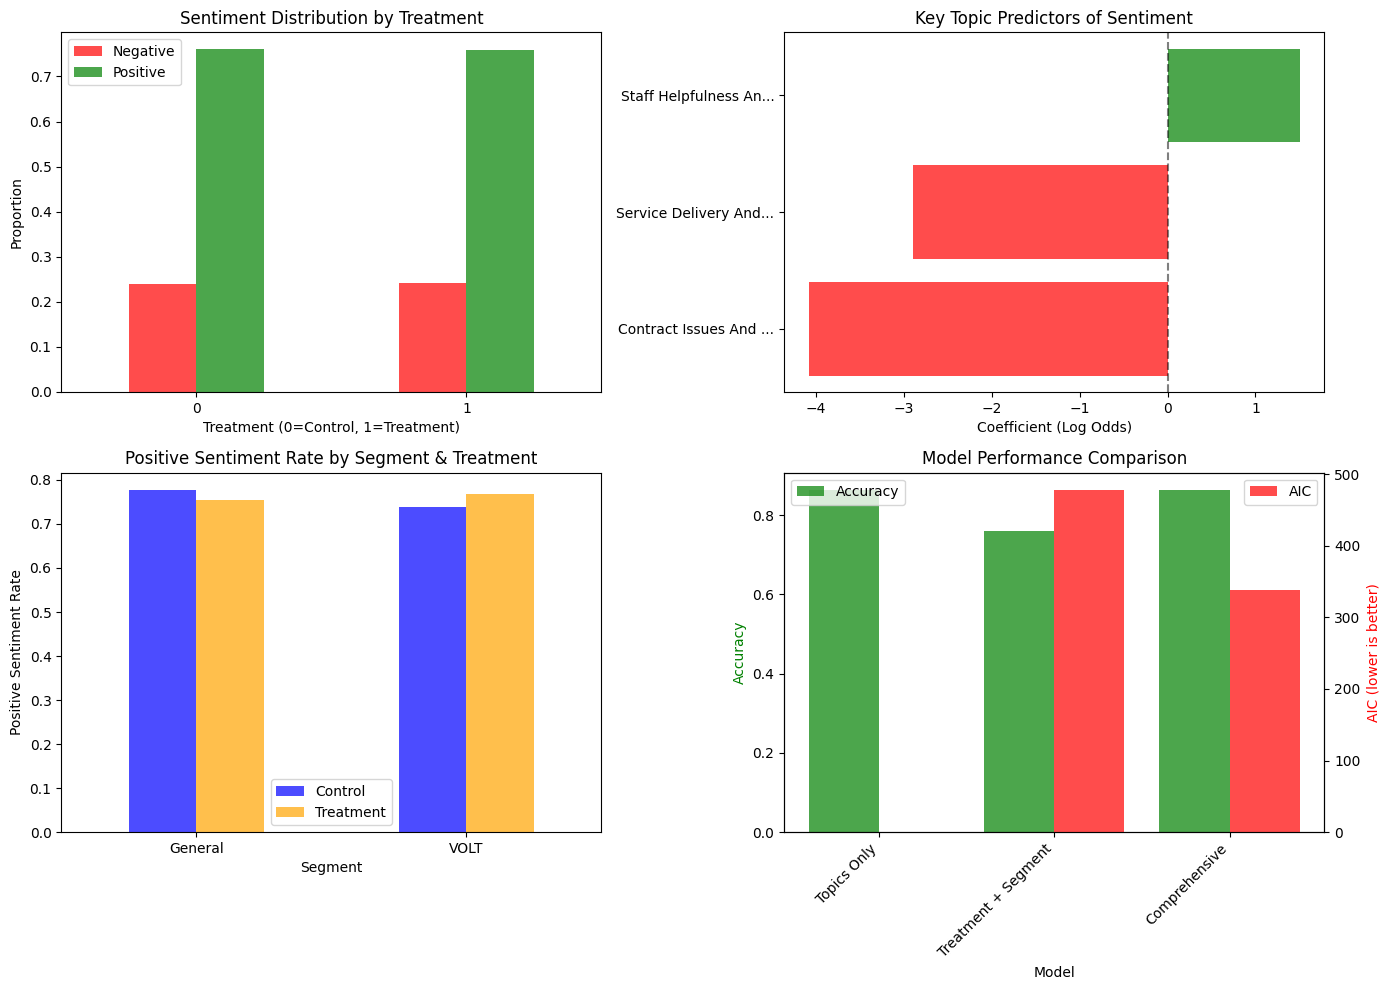


EXECUTIVE SUMMARY - CLASSIFICATION MODEL INSIGHTS
✓ Data: 428 comments, 76% positive sentiment
✓ Model accuracy: 86.4%

🎯 KEY SENTIMENT DRIVERS:
   📉 DECREASES sentiment: Contract Issues And Call Center Problems (OR: 0.02)
   📉 DECREASES sentiment: Service Delivery And Scheduling Issues (OR: 0.06)
   📈 INCREASES sentiment: Staff Helpfulness And Communication (OR: 4.50)

🧪 TREATMENT EFFECT:
   • No significant impact on overall sentiment (p = 0.919)
   • No significant impact on topic usage patterns
   • New script does NOT systematically change emotional tone

📊 MODEL INSIGHTS:
   • Topics are much stronger predictors than treatment assignment
   • Content matters more than script version for sentiment
   • Model explains 30.9% of sentiment variance


In [90]:
# --------------------------------------------------------
# 9) Visualization of key findings
# --------------------------------------------------------
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# 1. Sentiment distribution by treatment
sentiment_by_treatment = df_model.groupby(['TREATMENT_BINARY', 'sentiment_positive']).size().unstack()
sentiment_by_treatment_pct = sentiment_by_treatment.div(sentiment_by_treatment.sum(axis=1), axis=0)
sentiment_by_treatment_pct.plot(kind='bar', ax=ax1, color=['red', 'green'], alpha=0.7)
ax1.set_title('Sentiment Distribution by Treatment')
ax1.set_xlabel('Treatment (0=Control, 1=Treatment)')
ax1.set_ylabel('Proportion')
ax1.legend(['Negative', 'Positive'])
ax1.tick_params(axis='x', rotation=0)

# 2. Key topic effects on sentiment (odds ratios)
if len(significant_predictors) > 0:
    top_predictors = significant_predictors.head(5)
    topic_names = [name.replace('topic_', '').replace('_', ' ').title()[:20] + '...' 
                   if len(name.replace('topic_', '').replace('_', ' ').title()) > 20 
                   else name.replace('topic_', '').replace('_', ' ').title() 
                   for name in top_predictors['topic']]
    
    colors = ['red' if x < 0 else 'green' for x in top_predictors['coefficient']]
    bars = ax2.barh(range(len(topic_names)), top_predictors['coefficient'], color=colors, alpha=0.7)
    ax2.set_yticks(range(len(topic_names)))
    ax2.set_yticklabels(topic_names)
    ax2.set_xlabel('Coefficient (Log Odds)')
    ax2.set_title('Key Topic Predictors of Sentiment')
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# 3. Treatment effect across segments
segment_treatment_sentiment = df_model.groupby(['SEGMENT', 'TREATMENT_BINARY'])['sentiment_positive'].mean().unstack()
segment_treatment_sentiment.plot(kind='bar', ax=ax3, color=['blue', 'orange'], alpha=0.7)
ax3.set_title('Positive Sentiment Rate by Segment & Treatment')
ax3.set_xlabel('Segment')
ax3.set_ylabel('Positive Sentiment Rate')
ax3.legend(['Control', 'Treatment'])
ax3.tick_params(axis='x', rotation=0)

# 4. Model performance comparison
models = ['Topics Only', 'Treatment + Segment', 'Comprehensive']
treatment_pred = (treatment_model.predict() > 0.5).astype(int)
comprehensive_pred = (comprehensive_model.predict() > 0.5).astype(int)
accuracies = [0.864, (treatment_pred == df_model['sentiment_positive']).mean(), 
              (comprehensive_pred == df_model['sentiment_positive']).mean()]
aics = [0, treatment_model.aic, comprehensive_model.aic]

ax4_twin = ax4.twinx()
bars1 = ax4.bar([x-0.2 for x in range(len(models))], accuracies, width=0.4, alpha=0.7, color='green', label='Accuracy')
bars2 = ax4_twin.bar([x+0.2 for x in range(len(models))], aics, width=0.4, alpha=0.7, color='red', label='AIC')

ax4.set_xlabel('Model')
ax4.set_ylabel('Accuracy', color='green')
ax4_twin.set_ylabel('AIC (lower is better)', color='red')
ax4.set_title('Model Performance Comparison')
ax4.set_xticks(range(len(models)))
ax4.set_xticklabels(models, rotation=45, ha='right')

# Add legends
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')

plt.tight_layout()
save_plot(fig, 'sentiment_classification_analysis', 'sentiment_analysis')
plt.show()

# Summary insights
print("\n" + "="*60)
print("EXECUTIVE SUMMARY - CLASSIFICATION MODEL INSIGHTS")
print("="*60)
print(f"✓ Data: {len(df_model)} comments, {df_model['sentiment_positive'].mean():.0%} positive sentiment")
print(f"✓ Model accuracy: {(comprehensive_pred == df_model['sentiment_positive']).mean():.1%}")
print(f"\n🎯 KEY SENTIMENT DRIVERS:")
for _, row in significant_predictors.iterrows():
    direction = "📈 INCREASES" if row['coefficient'] > 0 else "📉 DECREASES"
    topic_clean = row['topic'].replace('topic_', '').replace('_', ' ').title()
    print(f"   {direction} sentiment: {topic_clean} (OR: {row['odds_ratio']:.2f})")

print(f"\n🧪 TREATMENT EFFECT:")
print(f"   • No significant impact on overall sentiment (p = {treatment_p:.3f})")
print(f"   • No significant impact on topic usage patterns")
print(f"   • New script does NOT systematically change emotional tone")

print(f"\n📊 MODEL INSIGHTS:")
print(f"   • Topics are much stronger predictors than treatment assignment")
print(f"   • Content matters more than script version for sentiment")
print(f"   • Model explains {comprehensive_model.prsquared:.1%} of sentiment variance")